In [13]:
import climakitae as ck
from climakitae.core.data_interface import get_data, get_data_options
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cm
try:
    from IPython.display import display
except ImportError:
    display = print("why is Ipyon not working")
mojaveShapeRelativePath: str = "../Mojave/Mojave_National_Preserve.shp" 
joshuaTreeShapeRelativePath: str = "../JoshuaTreeOutlines/JoshuaTree/Joshua_Tree_National_Park.shp"
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    isCartopyAvailable = True
except ImportError:
    print("Fix cartopy")
    
    ccrs = None
    isCartopyAvailable = False

In [14]:
#Configs
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] =150
standardCoordinateReferenceSystem = "EPSG:4326"
analysisVariablesDictionary = {"temp":"Air Temperature at 2m", "precip": "Precipitation (total)"}
dataSpatialResolution = "3 km"
historicalSimulationEndYear =2014
outputImageDirectory = "OutputImages"
os.makedirs(outputImageDirectory, exist_ok=True)
print(f"Output directory: {outputImageDirectory}")
diagnosticAnalysisTimeSpan = (1990, 2030)
diagnosticAnalysisScenarios = ["Historical Climate", "SSP 3-7.0", "SSP 2-4.5"]
mainAnalysisScenarios = ["Historical Climate", "SSP 3-7.0"]
baselinePeriodDefinition = {"name": "Baseline (1985-2014)", "years": (1985, 2014)}
futurePeriodDefinition = {"name": "Late-Century (2071-2100)", "years": (2071, 2100)}
mainAnalysisTimeSpan = (baselinePeriodDefinition["years"][0], futurePeriodDefinition["years"][1])

#All avalible availability cheques
testScenariosList =["Historical Climate", "SSP 1-2.6", "SSP 2-4.5", "SSP 3-7.0","SSP 5-8.5"]
testResolutionsList = ["3 km","6 km", "45 km"] #form wk 4 this is all that exits
testTimeSliceFuture = (2050, 2050)
testTimeSliceHistorical =(1990,1990)

print("\nAll configuration parameters defined.")

Output directory: OutputImages

All configuration parameters defined.


JTree Boundary Loaded. Bounds: Lat (np.float64(33.67018975804256), np.float64(34.129346624363556)), Lon (np.float64(-116.4580411520462), np.float64(-115.26220149792678))


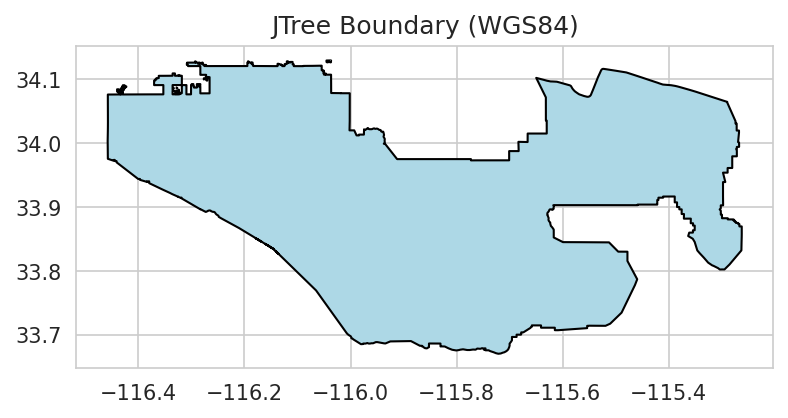

In [15]:
try:
    joshuaTreeBoundaryWgs84 =gpd.read_file(joshuaTreeShapeRelativePath)

    #is CRS is WGS84
    if joshuaTreeBoundaryWgs84.crs is None:
        joshuaTreeBoundaryWgs84.set_crs(standardCoordinateReferenceSystem, inplace=True)
        print("Jtree Crs is just WGS84, no worries")
    elif str(joshuaTreeBoundaryWgs84.crs) != standardCoordinateReferenceSystem:
        joshuaTreeBoundaryWgs84 = joshuaTreeBoundaryWgs84.to_crs(standardCoordinateReferenceSystem)

    boundaryBounds = joshuaTreeBoundaryWgs84.total_bounds
    # These variables are used in subsequent cells
    jtreeLongitudeSlice = (boundaryBounds[0], boundaryBounds[2])
    jtreeLatitudeSlice = (boundaryBounds[1],boundaryBounds[3])
    print(f"JTree Boundary Loaded. Bounds: Lat {jtreeLatitudeSlice}, Lon {jtreeLongitudeSlice}")

    # Visualize the boundary
    joshuaTreeBoundaryWgs84.plot(figsize=(6,6), edgecolor="black", facecolor="lightblue")
    plt.title("JTree Boundary (WGS84)")
    plt.show()

except Exception as e:
    print(f"Could not load shapefile from {joshuaTreeShapeRelativePath}: {e}")
    print("Using fallback bounding box.")
    joshuaTreeBoundaryWgs84 = None
    # Fallback bounds provided in initial context
    jtreeLongitudeSlice = (-116.6,-115.4)
    jtreeLatitudeSlice =(33.5, 34.3)

In [16]:
def convertDataUnits(dataArray, variableKey):
    processedDataArray = dataArray.copy()
    if variableKey == 'temp' and processedDataArray.attrs.get('units') =='K':
        processedDataArray = processedDataArray-273.15
        processedDataArray.attrs['units'] ='°C'

    elif variableKey == 'precip' and processedDataArray.attrs.get('units') in ['kg/m^2/s', 'kg m-2 s-1']:
        daysInMonth = processedDataArray.time.dt.days_in_month
        secondsPerDay =86400
        # (kg/m^2/s = mm/s)*(s/day) * (days/month) =mm/month
        processedDataArray = (processedDataArray *secondsPerDay) * daysInMonth
        processedDataArray.attrs['units'] = 'mm/month'
    return processedDataArray

def maskDataArrayToBoundary(dataArray, boundaryGdfWgs84):  
    if dataArray is None or boundaryGdfWgs84 is None: return dataArray
    dataCrs = dataArray.rio.crs
    if dataCrs is None:
        print("  Raster doesn't have CRS. Can't mask."); return dataArray
    #Reproj Boundary vec to match raster CRS
    try:
        if str(dataCrs) !=str(boundaryGdfWgs84.crs):
            
            boundaryNativeCrs = boundaryGdfWgs84.to_crs(dataCrs)
        else:
            boundaryNativeCrs =boundaryGdfWgs84
    except Exception as e:
        return dataArray

    #clean and trasnpose
    try:
        coordsToDrop = ['lon', 'landmask', 'lakemask'] #NEED to keep lat for weggiths to figure out and fix curvature.
        dataCleaned =dataArray.drop_vars(coordsToDrop, errors='ignore')
        
        #Get spatial dimens in robust manner
        try:
            spatialDims = (dataCleaned.rio.y_dim, dataCleaned.rio.x_dim)
        except Exception:
            if 'y' in dataCleaned.dims and 'x' in dataCleaned.dims:
                spatialDims = ('y','x')
            else:
                return dataArray
        nonSPatialDimenosn =[dim for dim in dataCleaned.dims if dim not in spatialDims]
        expectedOrder = tuple(nonSPatialDimenosn) + spatialDims
        if dataCleaned.dims!= expectedOrder:
            dataCleaned = dataCleaned.transpose(*expectedOrder)
    except Exception as e:
        print("problem, come here and check, now have: 'dataCleaned = dataArray'")
        dataCleaned = dataArray

    #Mask dat
    try:
        maskedDataArray = dataCleaned.rio.clip( boundaryNativeCrs.geometry.values,
            drop=False,       # Keep dimensions, mask values outside
            all_touched=True  #include partially overlapping pixels
        )
        maskedDataArray.attrs.update(dataArray.attrs)
        return maskedDataArray
    except Exception as e:
        print(f"   error with masking {e}"); return dataCleaned

def reprojectAndClipDataArray(dataArray, boundaryGdfWgs84):
    #L and M reproject raster data to standard CSR
    """Reprojects raster data to standard CRS and clips (reduces extent) to vec boundary."""
    if dataArray is None or boundaryGdfWgs84 is None: return None
    dataCrs = dataArray.rio.crs
    reprojectedData =dataArray

    # Reproj (Raster to standard CRS)
    if dataCrs is not None and str(dataCrs) != standardCoordinateReferenceSystem:
        try:
            coordsToDrop =['lon','landmask', 'lakemask']
            dataCleaned = dataArray.drop_vars(coordsToDrop, errors='ignore') 
            #identify spatial dimens
            try:
                spatialDims = (dataCleaned.rio.y_dim, dataCleaned.rio.x_dim)
            except Exception:
                if 'y' in dataCleaned.dims and 'x' in dataCleaned.dims:
                    spatialDims = ('y','x')
                else:
                    return dataArray

            nonSpatialDims =[dim for dim in dataCleaned.dims if dim not in spatialDims]
            expectedOrder = tuple(nonSpatialDims) + spatialDims
            if dataCleaned.dims !=expectedOrder:
                dataCleaned = dataCleaned.transpose(*expectedOrder)
            reprojectedData = dataCleaned.rio.reproject(standardCoordinateReferenceSystem)
        except Exception as e:
            print(f"   Error during reprojection: {e}."); return None

    #Clip 
    try:
        #drop=True reduces the spatial extent to the boundary
        clippedData = reprojectedData.rio.clip(
            boundaryGdfWgs84.geometry.values, drop=True, all_touched=True
        )
        clippedData.attrs.update(dataArray.attrs)
        return clippedData
    except Exception as e:
        print(f"   Error during clipping: {e}"); return None


#Diagnostic helpers

def diagnoseSpatialWeights(maskedDataArray):
    """Calculates and visualizes the latitude-based spatial weights."""
    if maskedDataArray is None: return None
    
    if 'lat' not in maskedDataArray.coords:
      print(f"\n--- Skipping spatial weights diagnosis for {maskedDataArray.name}: 'lat' coordinate missing. ---")
      return None

    print(f"\n--- Diagnosing spatial weights for {maskedDataArray.name} ---")
    #Inititial weights based on costine of latitiude -> for the area weighting
    weightsInitial = np.cos(np.deg2rad(maskedDataArray.lat))

    #need to see which pixels are inside the boundary -> not NAN and then check to see iff a pixel is valid acorss all te
    yDim = maskedDataArray.rio.y_dim or 'y'
    xDim = maskedDataArray.rio.x_dim or 'x'
    nonSpatialDims = [dim for dim in maskedDataArray.dims if dim not in [yDim, xDim]]

    if nonSpatialDims:
        # Check if there is ANY valid data point across time/simulations for a pixel
        isInsideBoundary = maskedDataArray.notnull().any(dim=nonSpatialDims)
    else:
        isInsideBoundary = maskedDataArray.notnull()

    #Apply mask: weights are NaN outside the boundary
    weightsMasked = weightsInitial.where(isInsideBoundary)

    # Final weights: set weights outside the boundary (NaNs) to 0
    weightsFinal = weightsMasked.fillna(0)

    # Visualise
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Helper to safely select a 2D slice for plotting if weights inherited extra dims
    def getPlotSlice(dataSlice):
        if hasattr(dataSlice, 'dims'):
            for dim in ['simulation', 'time', 'scenario']:
                    if dim in dataSlice.dims:
                        dataSlice = dataSlice.isel({dim: 0}, drop=True)
        return dataSlice

    # stages using XArray's .plot() to maintain coordinates
    getPlotSlice(weightsInitial).plot(ax=axes[0],cmap="plasma"); axes[0].set_title("1. Inital Weights (Lat-based)")
    getPlotSlice(weightsMasked).plot(ax=axes[1],cmap="plasma"); axes[1].set_title("2. Massckd Weights (NaN outside)")
    getPlotSlice(weightsFinal).plot(ax=axes[2], cmap="plasma"); axes[2].set_title("3. Final Weights (0 outside)")

    plt.suptitle("Diagnostic: Latitude Weighting Process"); plt.tight_layout(); plt.show()
    return weightsFinal

def checkDataQuality(dataArray, variableKey):
    """Performs basic quality checks on a subset of the data."""
    if dataArray is None: return
    print(f"\n--- Performing data quality checks on {variableKey} (first year subset) ---")

    # Select a small subset and load into memory for inspection
    try:
      subsetData = dataArray.isel(time=slice(0, 12)); subsetData.load()
    except Exception as e:
      print(f"   Could not load subset for quality check: {e}")
      return

    dataValues = subsetData.values

    # NaN and Inf checks
    nanCount = np.isnan(dataValues).sum(); print(f"   NaN Check: {nanCount} NaNs found.")
    if 'joshuaTreeBoundaryWgs84' in globals() and joshuaTreeBoundaryWgs84 is not None:
          print("     Note: NaNs are expected outside the masked boundary.")

    infCount = np.isinf(dataValues).sum(); print(f"   Infinity Check: {infCount} infinite values found.")

    #Value Range and Plausibility checks
    try:
        minValue, maxValue = np.nanmin(dataValues), np.nanmax(dataValues)
        dataUnits = dataArray.attrs.get('units')
        print(f"   Value Range: Min: {minValue:.4f}, Max: {maxValue:.4f} {dataUnits}")

        if variableKey == 'temp':
            if dataUnits == '°C' and (minValue < -50 or maxValue > 60):
                print("     ! Warning: Unrealistic temperatures detected (°C).")
            elif dataUnits =='K' and (minValue < 223 or maxValue > 333):
                 print("     ! Warning: Unrealistic temperatures detected (K).")
        elif variableKey == 'precip' and minValue < 0:
            print("     ! Warning: Negative precipitation values detected.")
    except Exception as e:
        print(f"   coundk't not determine value range (likely all NaNs): {e}")


def calculateSpatialAverage(maskedDataArray, spatialWeights):
    """Calculates the weighted or unweighted spatial average."""
    if maskedDataArray is None: return None
    try:
        xDim, yDim = maskedDataArray.rio.x_dim, maskedDataArray.rio.y_dim
        if spatialWeights is not None:
            print("   aplicaiton of latitude-based weights.")
            try:
                # Xarray actualyl gets the broadcasting of weights to match the data dimensions
                spatialAverage = maskedDataArray.weighted(spatialWeights).mean(dim=[xDim, yDim], skipna=True)
            except Exception as e:
                print(f"   weight failure: {e}. Falling back to unweighted mean.")
                spatialAverage = maskedDataArray.mean(dim=[xDim, yDim], skipna=True)
        else:
            print("   using unweighted mean (weights not provided or 'lat' missing).")
            spatialAverage = maskedDataArray.mean(dim=[xDim, yDim], skipna=True)

        # computation (Dask)
        spatialAverage.load()

        # Check if the result is valid
        if spatialAverage.isnull().all():
             print("   ! Warning: Spatial average resulted in all Null values.")
             return None

        return spatialAverage
    except Exception as e:
        print(f"   errror w/ calculating spatial average: {e}"); return None

def aggregateDataAnnually(spatialAverageData, variableKey):
    """Aggregates monthly time series data to annual."""
    if spatialAverageData is None: return None
    print(f"aggre data annually for {variableKey}...")

    #YE 
    #ye for repspeaign requencey
    if variableKey == 'precip':
        #annual total precip --> sum of monthly accumulations
        annualData = spatialAverageData.resample(time='YE').sum(dim='time', skipna=True)
        annualData.attrs['units'] = 'mm/year'
    else:
        #annual mean temperature
        annualData =spatialAverageData.resample(time='YE').mean(dim='time', skipna=True)
        annualData.attrs['units'] =spatialAverageData.attrs.get('units', '°C')
    return annualData


def plotAnnualSpread(annualData, variableKey):
    """Plots the annual time series showing individual simulations and the ensemble mean."""
    if annualData is None: return
    #conversts Xarray DataArray to Pandas DataFrame for plotting
    dataFrame = annualData.to_dataframe(name='Value').reset_index()
    if 'time' not in dataFrame.columns: return
    dataFrame['Year'] = dataFrame['time'].dt.year
    
    #clean up scnario names, and merged names by relabeling based on year, clean scenario names for plotting
    if 'scenario' in dataFrame.columns:
        stringToRemove = "Historical +";
        sspName = dataFrame['scenario'].astype(str).str.replace(stringToRemove, "", regex=False).str.strip()
        # det final scanrio label based offyear cuttoff
        dataFrame['ScenarioAdjusted'] = np.where(
            dataFrame['Year'] <= historicalSimulationEndYear,
            "Historical Climate",
            sspName
        )
        dataFrame.loc[dataFrame['scenario'] == "Historical Climate", 'ScenarioAdjusted'] = "Historical Climate"
    else:
        dataFrame['ScenarioAdjusted'] = "Unknown Scenario"
    #plotting
    plt.figure(figsize=(14, 7))

    #plot individual simulations (thin lines, low alpha)
    if 'simulation' in dataFrame.columns:
        sns.lineplot(data=dataFrame, x='Year', y='Value', hue='ScenarioAdjusted', units='simulation', estimator=None, alpha=0.2, linewidth=0.5)

    #pllot the ensemble mean  w/ a (thick line)
    sns.lineplot(data=dataFrame, x='Year', y='Value', hue='ScenarioAdjusted', linewidth=3, errorbar=None)

    plt.title(f"Anual {analysisVariablesDictionary.get(variableKey, variableKey)}: Simulation Spread and Ensemble Mean")
    plt.ylabel(f"Value ({annualData.attrs.get('units', '')})")
    #Trans vert line
    plt.axvline(x=historicalSimulationEndYear + 0.5, color='k', linestyle='--', linewidth=1, label=f'End of Historical ({historicalSimulationEndYear})')

    #cllean up legend to only show only ensemble means and the vertical line
    plotHandles, plotLabels = plt.gca().get_legend_handles_labels()
    uniqueScenarioLabels = dataFrame['ScenarioAdjusted'].unique()
    finalHandles = []
    finalLabels = []
    #add ascnario means (identified by thick linewidth)
    for handle, label in zip(plotHandles, plotLabels):
      if label in uniqueScenarioLabels and handle.get_linewidth() == 3:
          #prevent duplicate labels if seaborn adds them
          if label not in finalLabels:
            finalHandles.append(handle)
            finalLabels.append(label)

    #adddd the vertical line handle
    for handle, label in zip(plotHandles, plotLabels):
      if 'End of Historical' in label:
        finalHandles.append(handle)
        finalLabels.append(label)
        break

    plt.legend(handles=finalHandles, labels=finalLabels, title='Scenario / Event'); plt.grid(True); plt.show()

def plotSimulationDistribution(annualData, variableKey, yearsToCheckList):
    """Uses violin plots to show the distribution of values across simulations for specific years."""
    if annualData is None: return
    dataToPlotList = []
    # Extract data for specific years
    for year in yearsToCheckList:
        #annula data is  stamped at year-end (form: YYYY-12-31)
        try:
            yearData = annualData.sel(time=f"{year}-12-31")
            dataFrame = yearData.to_dataframe(name='value').reset_index(); dataFrame['Year'] = str(year)

            # det the appropriate scenario label based on the year
            if 'scenario' in dataFrame.columns:
                if year > historicalSimulationEndYear:
                    dataFrame['Scenario'] = dataFrame['scenario'].str.replace("Historical +", "", regex=False).str.strip()
                else:
                    dataFrame['Scenario'] = "Historical"
            else:
                 dataFrame['Scenario'] ="Unknown"

            dataToPlotList.append(dataFrame)
        except KeyError:
            print(f"  yEar {year} not found in the data.")
            continue

    if not dataToPlotList:
      print("   no data available for the queried years."); return

    #combine data and plot
    dataFrameCombined = pd.concat(dataToPlotList)

    plt.figure(figsize=(12, 6))
    # 'inner="point"' shows individual simulation values
    sns.violinplot(data=dataFrameCombined, x='Year', y='value', hue='Scenario', palette="coolwarm", inner="point", dodge=True)

    plt.title(f"Distribution of Annual {variableKey.capitalize()} Across Simulations")
    plt.ylabel(annualData.attrs.get('units')); plt.grid(True, axis='y', linestyle=':'); plt.show()

def plotSeasonalComparison(spatialAverageDataDictionary, variableKey):
    """Plots the average seasonal cycle (monthly climatology) for baseline and future periods."""
    if variableKey not in spatialAverageDataDictionary or spatialAverageDataDictionary[variableKey] is None: return
    data = spatialAverageDataDictionary[variableKey]
    print(f"plot seasonal comparison for {variableKey}...")

    #define periods based on diagnostic time span
    baselinePeriod = (diagnosticAnalysisTimeSpan[0],historicalSimulationEndYear)
    futurePeriod = (historicalSimulationEndYear + 1, diagnosticAnalysisTimeSpan[1])
    #get data for the periods
    baselineData = data.sel(time=slice(str(baselinePeriod[0]), str(baselinePeriod[1])))
    futureData = data.sel(time=slice(str(futurePeriod[0]), str(futurePeriod[1])))

    #cal monthly climatology (avg over the years in the period)
    baselineClimatology= baselineData.groupby('time.month').mean(dim='time' )
    futureClimatology = futureData.groupby('time.month').mean(dim='time')

    #conv to DataFrame for plotting
    dataFrameBase =    baselineClimatology.to_dataframe(name=variableKey).reset_index()
    dataFrameFuture = futureClimatology.to_dataframe( name=variableKey).reset_index()

    # clean up scaen names
    if 'scenario' in dataFrameFuture.columns:
      dataFrameFuture['scenario'] = dataFrameFuture['scenario'].str.replace("Historical + ", "", regex=False).str.strip()

    # Plotting
    plt.figure(figsize=(10, 6))
    #plot baseline (estimator='mean' across simulations, errorbar='sd' shows standard deviation)
    sns.lineplot(data=dataFrameBase,  x='month', y=variableKey, 
                 label=f"Baseline ({baselinePeriod[0]}-{baselinePeriod[1]})",
                   color='black', estimator='mean', errorbar='sd', 
                   linewidth=2)

    #plot future scenarios
    if 'scenario' in dataFrameFuture.columns:
      sns.lineplot(data=dataFrameFuture, x='month', y=variableKey, hue='scenario', estimator='mean', errorbar='sd', linewidth=2)
    else:
       sns.lineplot(data=dataFrameFuture, x='month', y=variableKey, label=f"Future ({futurePeriod[0]}-{futurePeriod[1]})", estimator='mean', errorbar='sd', linewidth=2, color='red')

    plt.title(f"Seasonal Cycle Comparison: {analysisVariablesDictionary.get(variableKey, variableKey)}")
    plt.ylabel(f"{variableKey.capitalize()} ({data.attrs.get('units', '')})"); plt.xlabel("Month"); plt.xticks(range(1, 13))
    plt.legend(title='Period/Scenario (Mean +/- 1 SD)'); plt.grid(True); plt.show()

def analyzeSpatialVariability(maskedDataArray, variableKey):
    """Analyzes how much variability exists within the spatial domain over time."""
    if maskedDataArray is None: return

    print(f"Analyzing spatial variability for {variableKey}...")

    # Calculate the standard deviation across the spatial dimensions (x, y) for each time step
    #calc std across spatial dimen (x,y) for all time stesp
    try:
        xDim = maskedDataArray.rio.x_dim
        yDim = maskedDataArray.rio.y_dim
        spatialStdDev = maskedDataArray.std(dim=[xDim, yDim], skipna=True)
        # Trigger computation
        spatialStdDev.load()
    except Exception as e:
        print(f"   Error calculating spatial standard deviation: {e}")
        return

    #agg monthly spatial STD to annual average spatial STD
    annualSpatialStdDev = spatialStdDev.resample(time='YE').mean(dim='time')

    #conv to DataFrame for plotting
    dataframe = annualSpatialStdDev.to_dataframe(name='Spatial_STD').reset_index()
    if 'time' not in dataframe.columns: return
    dataframe['Year'] = dataframe['time'].dt.year

    #ajd Scenario names 
    if 'scenario' in dataframe.columns:
        sspName = dataframe['scenario'].str.replace("Historical +", "", regex=False).str.strip()
        dataframe['Scenario_Adjusted'] = np.where(dataframe['Year'] <= historicalSimulationEndYear, "Historical Climate", sspName)
        dataframe.loc[dataframe['scenario'] == "Historical Climate", 'Scenario_Adjusted'] = "Historical Climate"
    else:
        dataframe['Scenario_Adjusted'] = "Unknown Scenario"

    #plotting
    plt.figure(figsize=(12, 6))
    #plot the ensemble mean of the spatial standard deviation over time
    sns.lineplot(data=dataframe, x='Year', y='Spatial_STD', hue='Scenario_Adjusted', estimator='mean')

    plt.title(f"Average Annual Spatial Standard Deviation within JTree Boundary ({variableKey})")
    plt.ylabel(f"Spatial STD ({maskedDataArray.attrs.get('units')})")
    plt.axvline(x=historicalSimulationEndYear + 0.5, color='k', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

#avaliability check helpers (16+)
def aggregateAvailabilityStatus(statusSeries):
    # Determines the overall availability status based on individual test results
    if "Failure" in statusSeries.values or "Error" in statusSeries.values:
        return "Unavailable"
    elif "Success" in statusSeries.values:
        return "Available"
    return "N/A"

def styleAvailabilityPivot(value):
    #just stypying 
    color = 'lightgreen' if value == 'Available' else 'salmon' if value == 'Unavailable' else 'white'
    return f'background-color: {color}'

def plotDiscretePanel(ax, data, cmapName, title, boundaryGdfWgs84=None, mapProjection=None, plotExtent=None, numBins=8, center=None):
    """Helper function for plotting a single panel with a discrete color scale."""
    if hasattr(data.data, 'dask'):
        data.load()

    #det color scale limits
    try:
      vmin, vmax = np.nanpercentile(data, [5, 95])
    except Exception:
       return None

    #det bins for discrete scale
    if center is not None:
        # Diverging map
        vlim = max(abs(vmin),   abs(vmax))
        nBins = numBins if numBins % 2 == 0 else numBins + 1
        levels = np.linspace(-vlim, vlim, nBins + 1)
    else:
        #s  qeuential map
        levels =   np.linspace(vmin, vmax, numBins + 1)
 
    #create the colormap and normalization
    try:
        # Use modern matplotlib access
        cmap =plt.colormaps[cmapName].resampled(len(levels) - 1)
    except (KeyError, AttributeError):
        #fallback for older versions or missing cmap
        try:
            cmap = plt.get_cmap(cmapName, len(levels) - 1)
        except:
            cmap = plt.get_cmap('viridis',len(levels) - 1) # ultimate fallback

    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    transform = mapProjection if mapProjection else ax.transData

    #plot the data
    mesh = data.plot.pcolormesh(
        ax=ax, transform=transform, cmap=cmap, norm=norm, add_colorbar=False
    )

    if plotExtent and mapProjection:
        ax.set_extent(plotExtent, crs=mapProjection)

    if boundaryGdfWgs84 is not None:
        boundaryGdfWgs84.boundary.plot(ax=ax, color='black', linewidth=1.2)

    ax.set_title(title)
    return mesh
print("All helper functions defined.")

All helper functions defined.


In [17]:

try:
    from IPython.display import display
except ImportError:
    display = print("bruh")
try:
    #checck if the dictionary exists and is not empty
    if not analysisVariablesDictionary:
        print("analysisVariablesDictionary is empty, cell 2.")
except NameError:
    print("analysisVariablsDictionary not found,  Cell 2.")


for key,variableName in analysisVariablesDictionary.items():
    try:
        rawOptionsDataFrame =get_data_options(variable=variableName)
        print("Type:", type(rawOptionsDataFrame))
        if isinstance(rawOptionsDataFrame, pd.DataFrame):
            print("Columns Found:",rawOptionsDataFrame.columns.tolist())
            print("DataFrame Head:")
            display(rawOptionsDataFrame.head())
        else:
            print("Output (non-DataFrame):")
            print(rawOptionsDataFrame)
    except Exception as e:
        print(f"error w/  diagnostic: {e}")

Type: <class 'pandas.core.frame.DataFrame'>
Columns Found: ['variable', 'resolution']
DataFrame Head:


variable  \
downscaling_method scenario           timescale                          
Dynamical          Historical Climate hourly     Air Temperature at 2m   
                                      hourly     Air Temperature at 2m   
                                      hourly     Air Temperature at 2m   
                   SSP 3-7.0          hourly     Air Temperature at 2m   
                                      hourly     Air Temperature at 2m   

                                                resolution  
downscaling_method scenario           timescale             
Dynamical          Historical Climate hourly         45 km  
                                      hourly          9 km  
                                      hourly          3 km  
                   SSP 3-7.0          hourly         45 km  
                                      hourly          9 km

Type: <class 'pandas.core.frame.DataFrame'>
Columns Found: ['variable', 'resolution']
DataFrame Head:


variable  \
downscaling_method scenario           timescale                          
Statistical        Historical Climate daily      Precipitation (total)   
                                      monthly    Precipitation (total)   
                   SSP 2-4.5          daily      Precipitation (total)   
                                      monthly    Precipitation (total)   
                   SSP 3-7.0          daily      Precipitation (total)   

                                                resolution  
downscaling_method scenario           timescale             
Statistical        Historical Climate daily           3 km  
                                      monthly         3 km  
                   SSP 2-4.5          daily           3 km  
                                      monthly         3 km  
                   SSP 3-7.0          daily           3 km

In [18]:
#Initial check for resolutions (Handles the minimal metadata case)

print("\nStep 1: Checking available resolutions broadly.")
isResolutionSupportedDictionary = {}

for key, variableName in analysisVariablesDictionary.items():
    print(f"\n--- Variable: {variableName} ({key}) ---")
    isResolutionSupportedDictionary[key] = False
    try:
        #query options just by variable (as observed, this often returns minimal metadata)
        optionsByVariableDataFrame = get_data_options(variable=variableName)

        # Check if the essential 'resolution' column is present
        if not isinstance(optionsByVariableDataFrame, pd.DataFrame) or 'resolution' not in optionsByVariableDataFrame.columns:
            print(f"     Error: 'resolution' column missing or output not a DataFrame. Found Columns: {getattr(optionsByVariableDataFrame, 'columns', 'N/A')}")
            continue

        #identify available resolutions
        availableResolutionsList = optionsByVariableDataFrame['resolution'].unique()
        # Sorting for consistent display
        print(f"     Available Resolutions: {sorted(list(availableResolutionsList))}")

        # Check if target resolution is supported
        if dataSpatialResolution in availableResolutionsList:
            isResolutionSupportedDictionary[key] = True
            print(f"     ststus target resolution ({dataSpatialResolution}) isn't supported.")
        else:
            print(f"     wrnign Desired resolution '{dataSpatialResolution}' not available for {key}.")

    except Exception as e:
        print(f"   error during Step 1 (Resolution Check): {e}")


# Step 2 & 3: attempy to get detailed options and analyze them
print(f"\nStep 2 & 3: Querying and analyzing detailed options for Resolution: {dataSpatialResolution}")
for key, variableName in analysisVariablesDictionary.items():
    print(f"\n--- Variable: {variableName} ({key}) @ {dataSpatialResolution} ---")

    #skip iff the resolution was already found to be unsupported
    if not isResolutionSupportedDictionary.get(key, False):
        print("   skip detailed check as resolution is not supported.")
        continue

    try:
        # new start: Query with Variable AND Resolution simultaneously
        #may may prompt the API to return detailed metadata (scenarios, simulations).
        detailedOptionsDataFrame = get_data_options(
            variable=variableName,
            resolution=dataSpatialResolution
        )

        # diag output
        if not isinstance(detailedOptionsDataFrame, pd.DataFrame):
            print(f"   Error: Expected a DataFrame but got {type(detailedOptionsDataFrame)}")
            continue

        # crit check to see iff scneaio is present: Is 'scenario' present now?
        if 'scenario' not in detailedOptionsDataFrame.columns:
            #case when more metadata still not there
            print(f"   ! Ugh Detailed metadata ('scenario', 'simulation', etc.) is still missing even when filtering by resolution.")
            print(f"   cols Found: {detailedOptionsDataFrame.columns.tolist()}")
            print(f"   May confirms the catalog does not provide scenario/simulation details upfront for this combination.")
            print("   Ergo, must rely on actual data retrieval tests now: (Cells 6 and 17) to confirm availability.")
            continue

        #prceed with analysis
        print("   detailed metadata found. Analyzing simulation counts...")

        # Filter by timescale/frequency
        #filter by timescale
        subsetDataFrame = detailedOptionsDataFrame.copy()
        timeScaleColumn = None
        if 'timescale' in detailedOptionsDataFrame.columns:
            timeScaleColumn = 'timescale'
        elif 'frequency' in detailedOptionsDataFrame.columns:
            timeScaleColumn ='frequency'

        if timeScaleColumn:
            subsetDataFrame = subsetDataFrame[subsetDataFrame[timeScaleColumn] =='monthly']
            print("   filtered for 'monthly' data.")
        else:
            print("   note: 'timescale' or 'frequency' columns not found. Assuming relevant timescale.")

        if subsetDataFrame.empty:
            print(f"   there is no (monthly) data available for this variable/resolution combination.")
            continue

        #smimul count per scenario
        print(f"\n   sim/Source Counts:")

        # handle the simulation identifier column (as 'simulation' might be missing).
        simulationIdentifierColumn = None
        #list potential columns identifying unique model runs
        potentialIdentifiersList = ['simulation', 'source','model', 'source_id']

        for identifier in potentialIdentifiersList:
            if identifier in subsetDataFrame.columns:
                simulationIdentifierColumn = identifier
                break
        if simulationIdentifierColumn:
            print(f"     (counting unique values in column: '{simulationIdentifierColumn}')")
            #group by scenario and count the unique simulations/sources
            simulationCountsSeries = subsetDataFrame.groupby('scenario')[simulationIdentifierColumn].nunique().sort_values(ascending=False)
            print(simulationCountsSeries)
        else:
            #iff no suitable identifier column is found
            print("     (Could not identify simulation/model identifier column. Counting total entries per scenario.)")
            simulationCountsSeries = subsetDataFrame['scenario'].value_counts().sort_values(ascending=False)
            print(simulationCountsSeries)

    except Exception as e:
        #generic error handling
        print(f"errr retrieving or processing options: {e}")


Step 1: Checking available resolutions broadly.

--- Variable: Air Temperature at 2m (temp) ---
     Available Resolutions: ['3 km', '45 km', '9 km']
     ststus target resolution (3 km) isn't supported.

--- Variable: Precipitation (total) (precip) ---
     Available Resolutions: ['3 km', '45 km', '9 km']
     ststus target resolution (3 km) isn't supported.

Step 2 & 3: Querying and analyzing detailed options for Resolution: 3 km

--- Variable: Air Temperature at 2m (temp) @ 3 km ---
   ! Ugh Detailed metadata ('scenario', 'simulation', etc.) is still missing even when filtering by resolution.
   cols Found: ['variable', 'resolution']
   May confirms the catalog does not provide scenario/simulation details upfront for this combination.
   Ergo, must rely on actual data retrieval tests now: (Cells 6 and 17) to confirm availability.

--- Variable: Precipitation (total) (precip) @ 3 km ---
   ! Ugh Detailed metadata ('scenario', 'simulation', etc.) is still missing even when filtering 

In [19]:
diagnosticDataDictionary = {}
#ensure spatial slices are defined before proceeding
if jtreeLatitudeSlice is None or jtreeLongitudeSlice is None:
    print("errr: spat boundary slices (latitude/longitude) are not defined. i think run Cell 3")
else:
    print(f"\load diagnostic data subset (Monthly, {dataSpatialResolution}, {diagnosticAnalysisTimeSpan})...")
    for key, variableName in analysisVariablesDictionary.items():
        print(f"retreviging {key}...")
        try:
            data = get_data(
                variable=variableName,
                resolution=dataSpatialResolution,
                timescale="monthly",
                scenario=diagnosticAnalysisScenarios,
                time_slice=diagnosticAnalysisTimeSpan,
                latitude=jtreeLatitudeSlice,
                longitude=jtreeLongitudeSlice
            )
            #check iff data was successfully retrieved
            if data is not None and data.time.size > 0:
                #assaign the variable key as the name of the DataArray
                data.name = key
                diagnosticDataDictionary[key] = data
                print(f"   success. dimens: {data.dims}, Size: {data.nbytes / 1e9:.2f} GB (Lazy)")
            else:
                print(f"   No data returned for {key}. Check spatial coverage and catalog availability-> run cell 5.")
        except Exception as e:
            print(f"   Error retrieving {key}: {e}")

\load diagnostic data subset (Monthly, 3 km, (1990, 2030))...
retreviging temp...


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_685/2586740282.py:6: SyntaxWarning: invalid escape sequence '\l'
  print(f"\load diagnostic data subset (Monthly, {dataSpatialResolution}, {diagnosticAnalysisTimeSpan})...")


   success. dimens: ('scenario', 'simulation', 'time', 'y', 'x'), Size: 0.02 GB (Lazy)
retreviging precip...
   success. dimens: ('scenario', 'simulation', 'time', 'y', 'x'), Size: 0.02 GB (Lazy)


In [20]:
#cell 7 detaield xarray strcutre inspection (diag)
if not diagnosticDataDictionary:
    print("No diagnostic data loaded.")
else:
    for key, data in diagnosticDataDictionary.items():
        print(f"\n{'='*60}\nInspecting Variable: {key}\n{'='*60}")
        #[print the full Xarray representation
        print("strucutre overview:"); print(data); print(f"{'-'*60}")

        #coords Detail
        print("key Coordinates Detail:")
        if 'scenario' in data.coords:
              print(f"   scenarios: {data.scenario.values}")
        if 'simulation' in data.dims:
            print(f"   simuls (Count): {len(data.simulation.values)}")

        #time dimension analysis
        try:
            timeIndex = data.time.to_index()
            print(f"   tome Start: {timeIndex.min()}"); print(f"   tiem End: {timeIndex.max()}")
            inferredFrequency = pd.infer_freq(timeIndex)
            print(f"   time Frequency (Inferred): {inferredFrequency}")
            #check for irregular frequency
            if inferredFrequency is None or not (inferredFrequency.startswith('MS') or inferredFrequency.startswith('ME')):
                  print("     ! Warning: Time frequency is irregular or not monthly.");
        except Exception as e:
            print(f"   Error analyzing time dimension: {e}")
        print(f"{'-'*60}")

        # CRS Information
        print("crs info (via rioxarray):")
        dataCrs = data.rio.crs
        if dataCrs:
            print(f"   crs: {dataCrs.to_string()[:100]}...")
            print(f"   spatial dimens: x='{data.rio.x_dim}', y='{data.rio.y_dim}'")
        else:
            print("   ! CRS: Not Found");
        print(f"{'-'*60}")

        #aux coord Shape Check
        print("Auxiliary Coordinate Shapes Check:")
        auxiliaryCoordinates = ['lat', 'lon', 'landmask', 'lakemask']
        yDim = data.rio.y_dim or 'y'
        xDim = data.rio.x_dim or 'x'
        dataShape = (data.sizes.get(yDim, 'N/A'), data.sizes.get(xDim, 'N/A'))
        print(f"   main Data Shape ({yDim}, {xDim}): {dataShape}")

        mismatchDetected = False
        for coordinate in auxiliaryCoordinates:
            if coordinate in data.coords:
                coordinateShape = (data[coordinate].sizes.get(yDim, 'N/A'), data[coordinate].sizes.get(xDim, 'N/A'))
                print(f"   - cooord '{coordinate}' Shape ({yDim}, {xDim}): {coordinateShape}")
                if coordinateShape != dataShape:
                    print(f"     uh oh -> Shape mismatch for '{coordinate}'. needs to be dropped before reproj/masking."); mismatchDetected = True

        if not mismatchDetected:
            print("   no shape mismatches found")


Inspecting Variable: temp
strucutre overview:
<xarray.DataArray 'temp' (scenario: 1, simulation: 8, time: 492, y: 33, x: 39)> Size: 20MB
dask.array<broadcast_to, shape=(1, 8, 492, 33, 39), dtype=float32, chunksize=(1, 1, 226, 33, 39), chunktype=numpy.ndarray>
Coordinates:
    lakemask           (y, x) float32 5kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 5kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 5kB 33.25 33.27 33.28 ... 34.54 34.55
    lon                (y, x) float32 5kB -116.1 -116.1 -116.0 ... -115.7 -115.6
  * time               (time) datetime64[ns] 4kB 1990-01-01 ... 2030-12-01
  * x                  (x) float64 312B -4.002e+06 -3.999e+06 ... -3.888e+06
  * y                  (y) float64 264B 6.679e+05 6.709e+05 ... 7.639e+05
    Lambert_Conformal  int64 8B 0
  * simulation         (simulation) <U26 832B 'WRF_CESM2_r11i1p1f1' ... 'WRF_...
  * scenario           (scenario) <U22 88B 'Historical + SSP 3-7.0'
Attr


--- Processing temp ---
   aplpitng spatial mask...


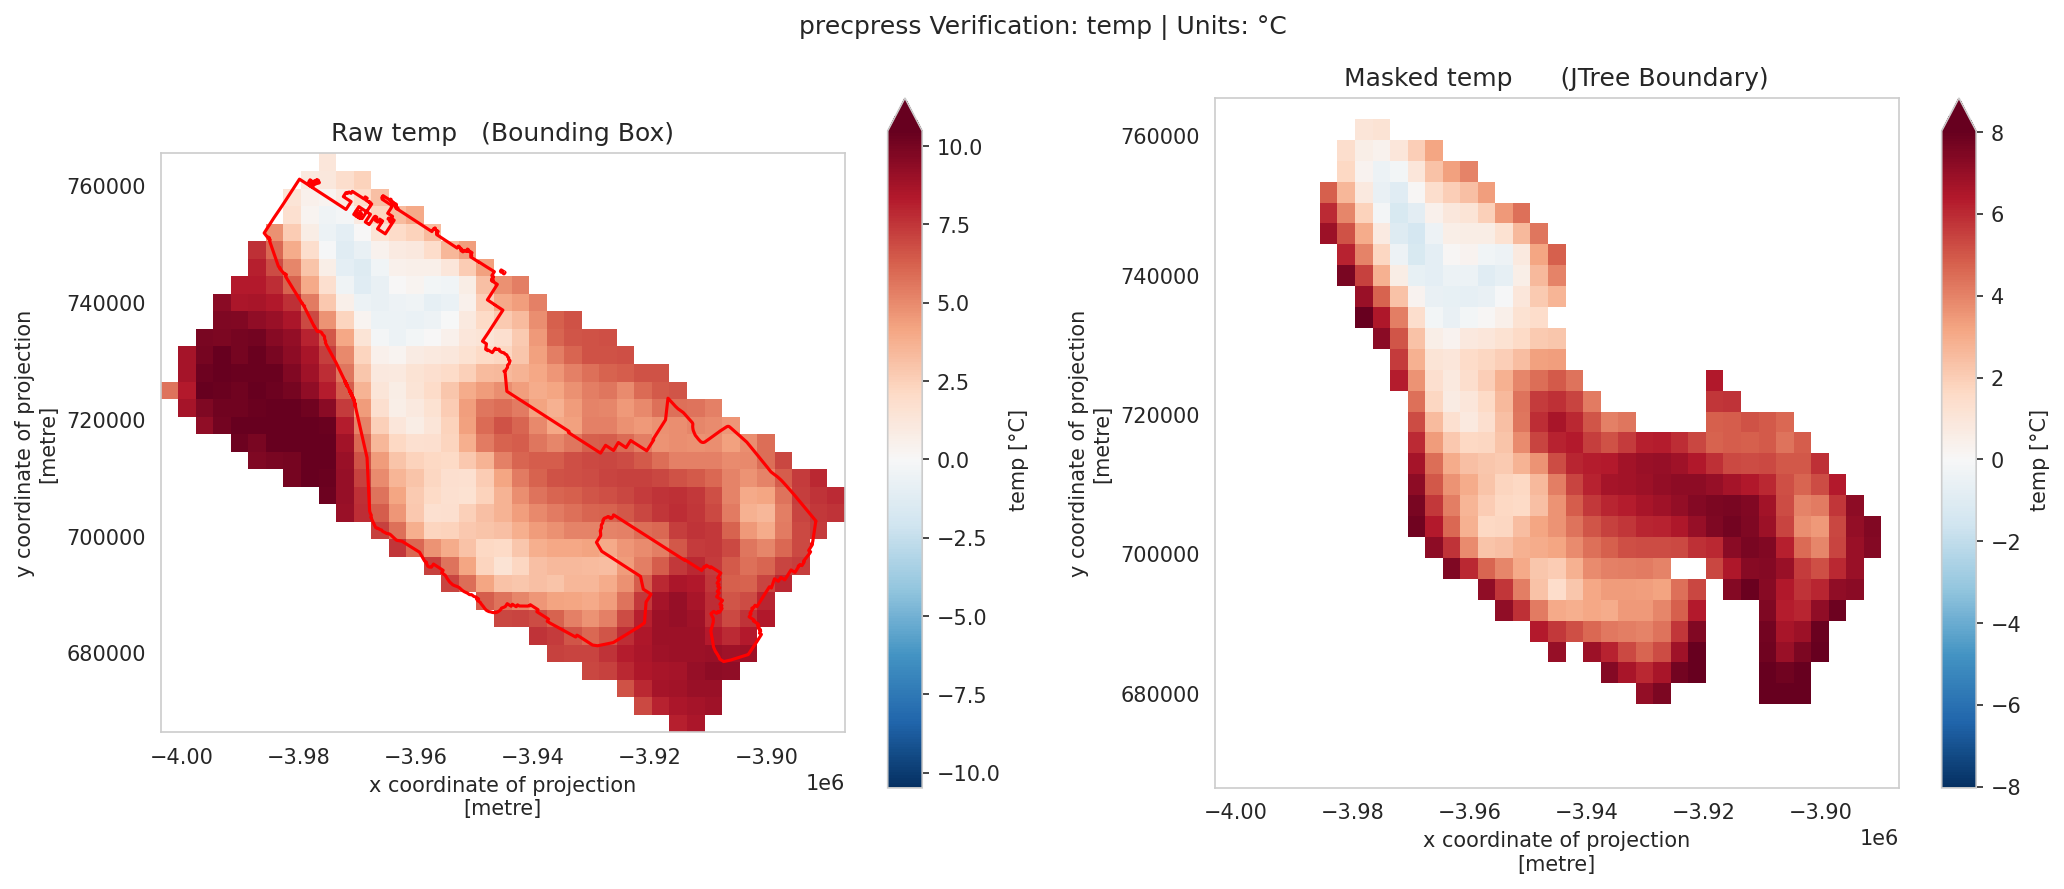


--- Processing precip ---
   aplpitng spatial mask...


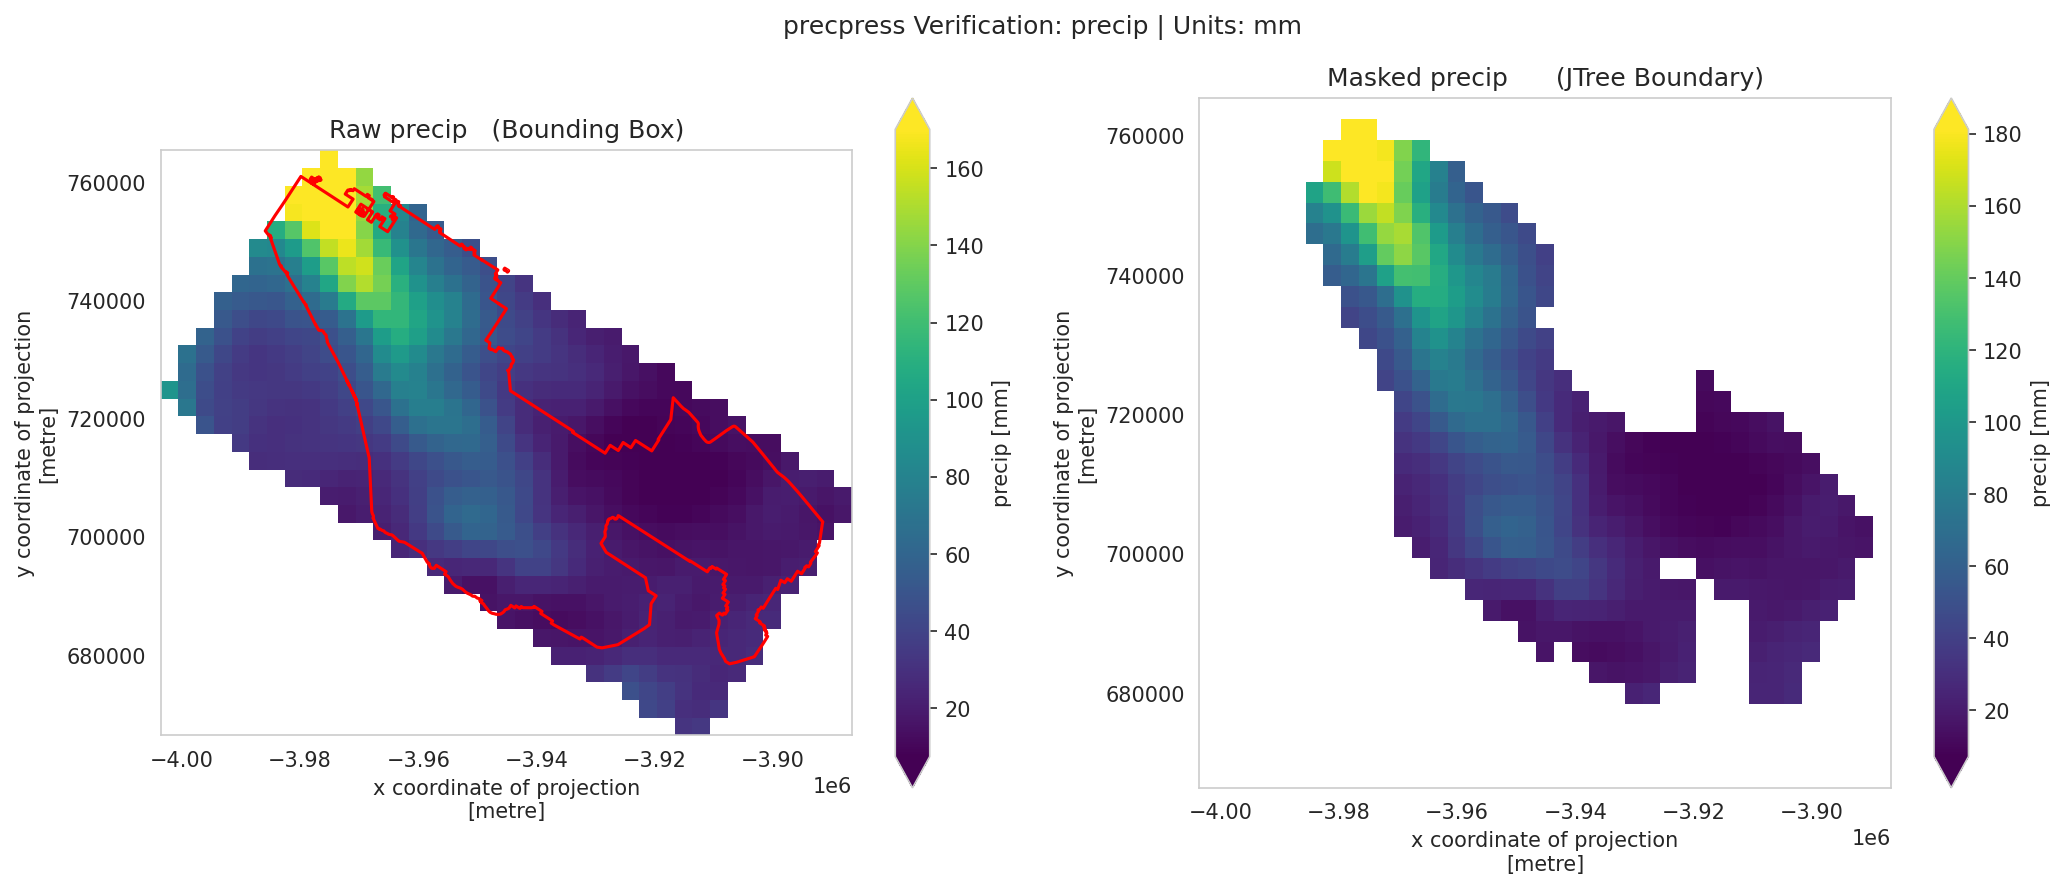

In [21]:

#apply preprocessing and visual verification (dagnostic)
processedDiagnosticData = {}
if not diagnosticDataDictionary:
    print("diag data not loaded.")
else:
    for key, data in diagnosticDataDictionary.items():
        print(f"\n--- Processing {key} ---")

        #unit Conversion
        dataWithConvertedUnits = convertDataUnits(data, key)

        #spatial Masking
        if joshuaTreeBoundaryWgs84 is not None:
            print("   aplpitng spatial mask...")
            maskedDataArray = maskDataArrayToBoundary(dataWithConvertedUnits, joshuaTreeBoundaryWgs84)
        else:
            print("   skipping spatial masking (boundary not loaded).")
            maskedDataArray = dataWithConvertedUnits

        # Store the processed data
        if maskedDataArray is not None:
            maskedDataArray.name = key # Ensure name is retained
            processedDiagnosticData[key] = maskedDataArray

        #Verification Plots
        if maskedDataArray is not None:
            try:
                # Select a single time slice and simulation
                selectionKwargs = {'time': 0}
                if 'simulation' in dataWithConvertedUnits.dims:
                    selectionKwargs['simulation'] = 0

                sampleRawData = dataWithConvertedUnits.isel(**selectionKwargs).squeeze(drop=True)
                sampleMaskedData = maskedDataArray.isel(**selectionKwargs).squeeze(drop=True)

                #load data into memory before plotting (if Dask)
                if hasattr(sampleRawData, 'load'): sampleRawData.load()
                if hasattr(sampleMaskedData, 'load'): sampleMaskedData.load()

                #plotting
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                sampleRawData.plot(ax=axes[0], robust=True); axes[0].set_title(f"Raw {key}   (Bounding Box)")
                sampleMaskedData.plot(ax=axes[1], robust=True); axes[1].set_title(f"Masked {key}      (JTree Boundary)")

                #overlay the boundary on the raw plot for context
                if joshuaTreeBoundaryWgs84 is not None:
                    dataCrs = dataWithConvertedUnits.rio.crs
                    if dataCrs:
                        try:
                            #reprok boundary to the CRS of the data for accurate overlay
                            boundaryNativeCrs = joshuaTreeBoundaryWgs84.to_crs(dataCrs)
                            boundaryNativeCrs.boundary.plot(ax=axes[0], color='red', linewidth=1.5)
                        except Exception:
                            pass #silent fial fail overlay if CRS issues occur

                plt.suptitle(f"precpress Verification: {key} | Units: {maskedDataArray.attrs.get('units')}")
                plt.tight_layout(); plt.show()

            except Exception as e:
                print(f"   couldn't not generate verification plots: {e}")


--- Diagnosing spatial weights for temp ---


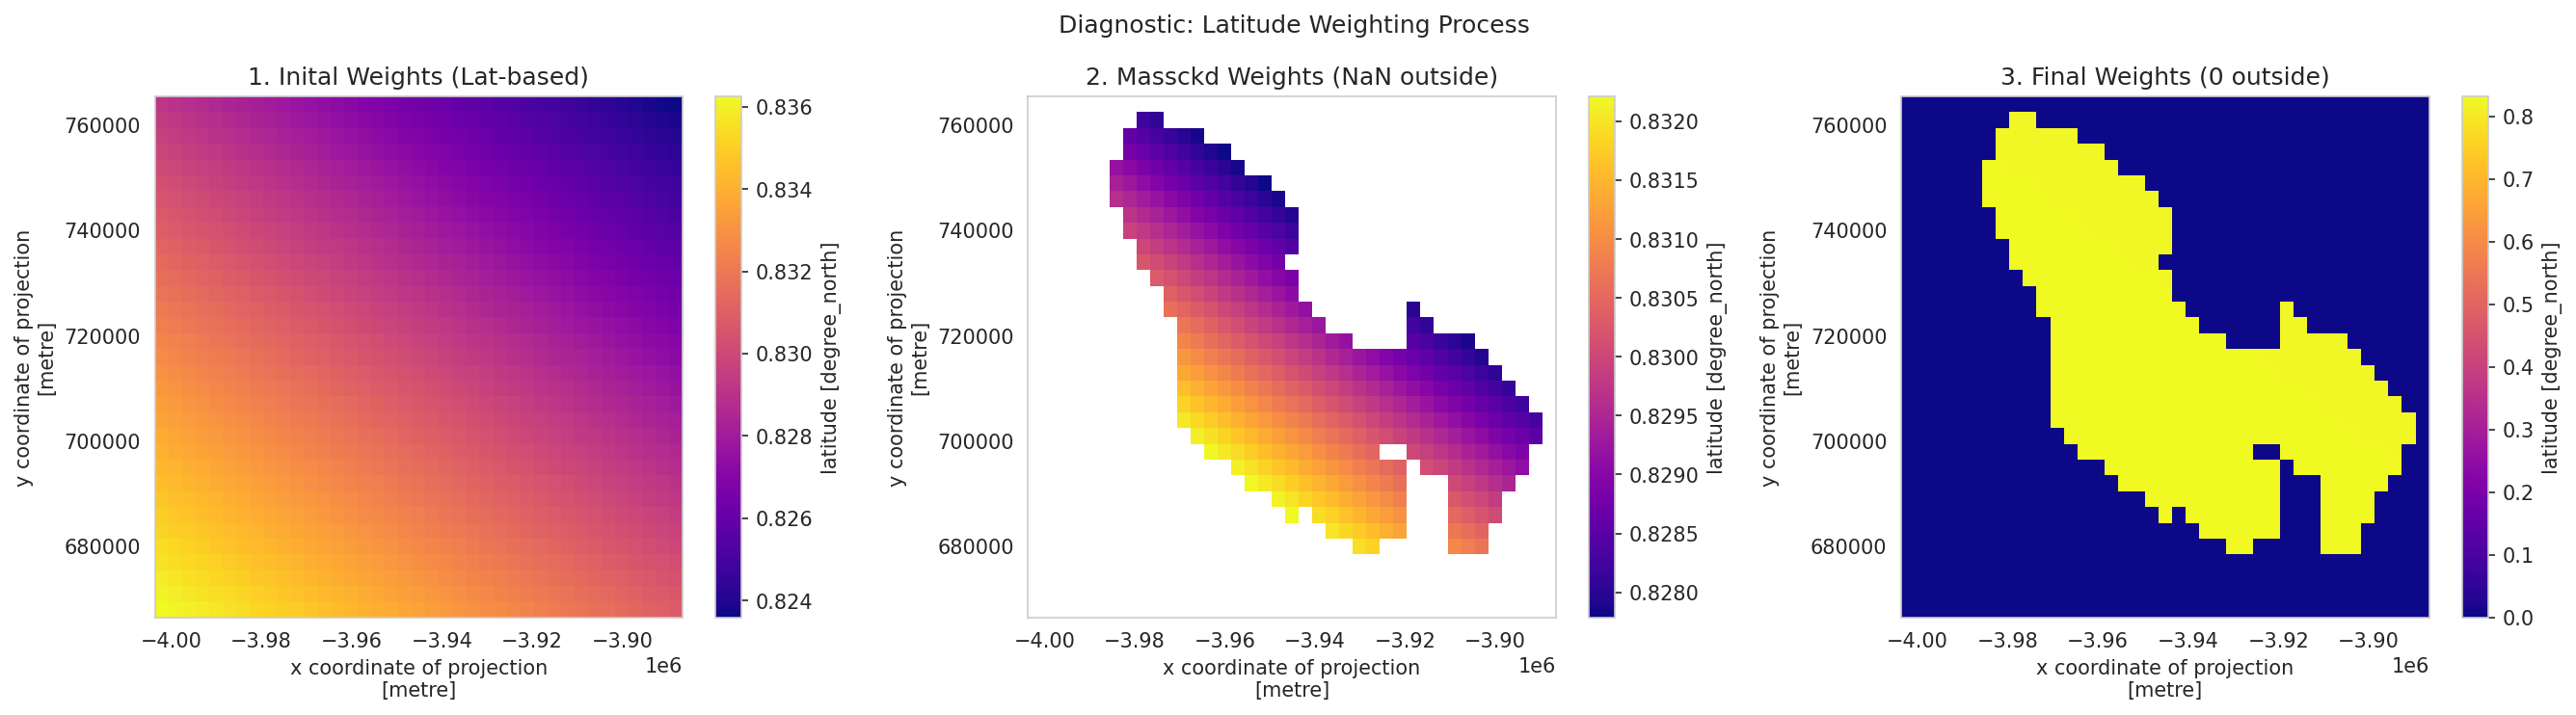


--- Diagnosing spatial weights for precip ---


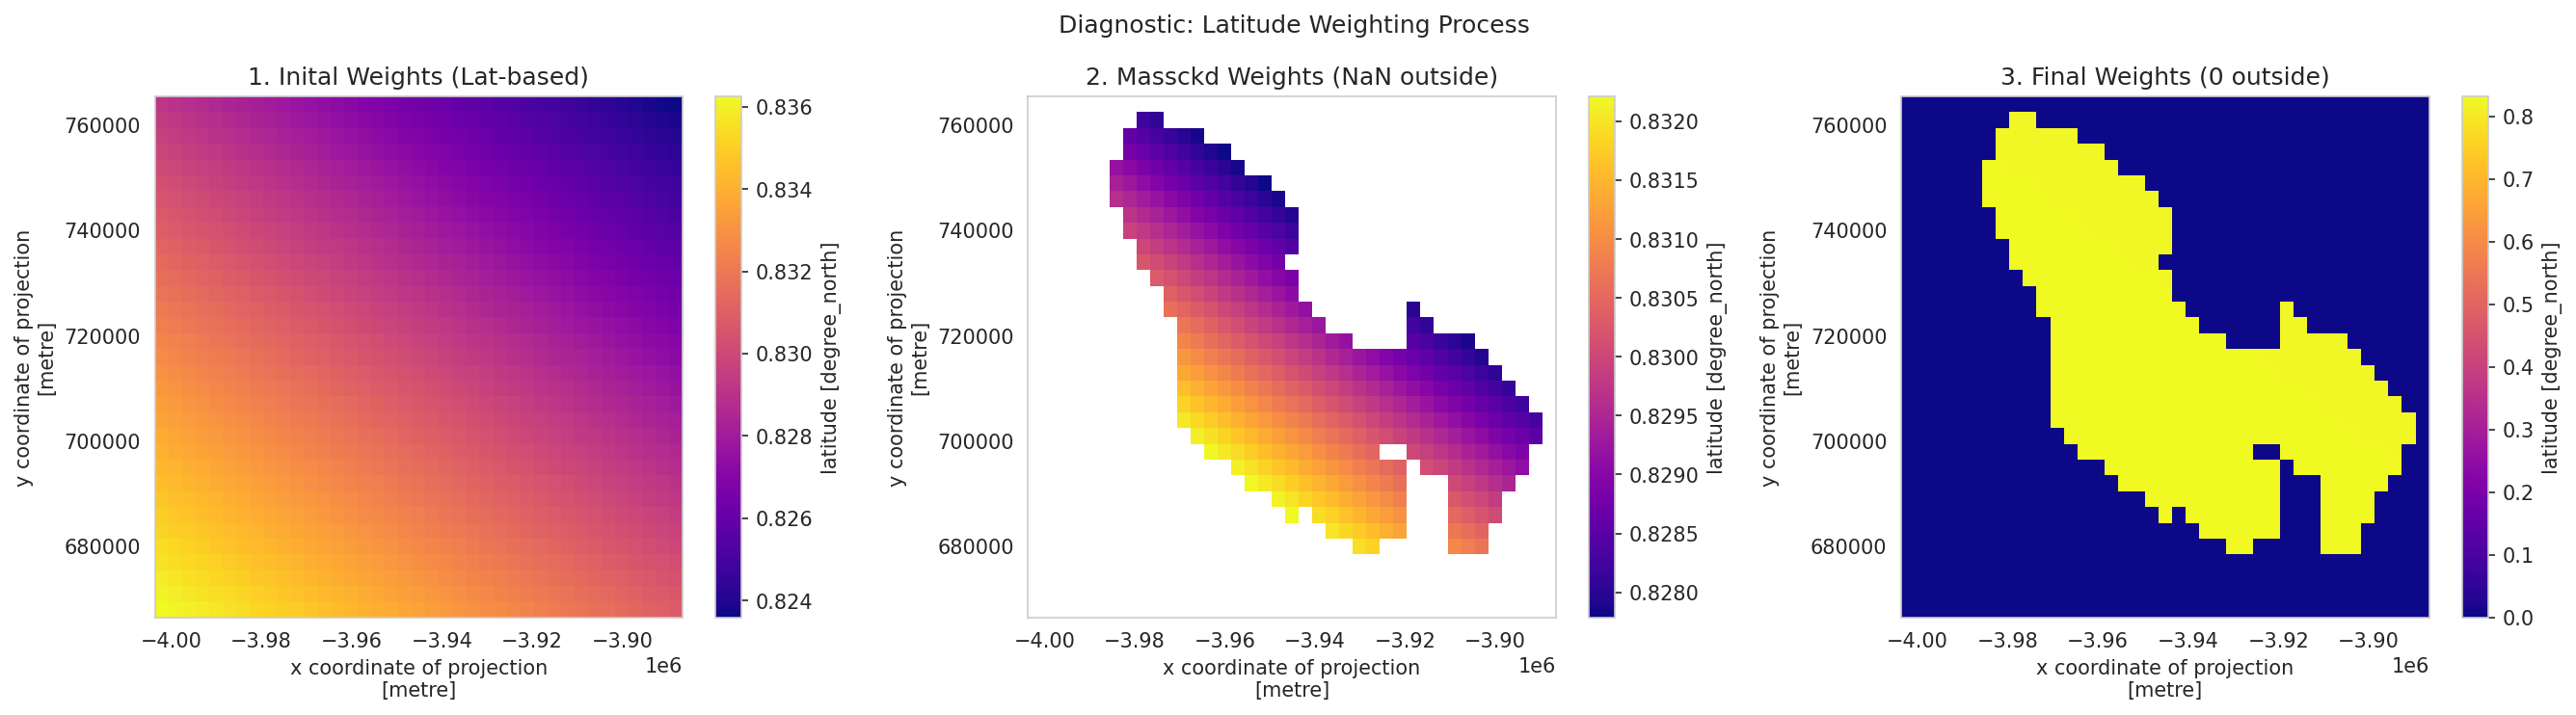

In [22]:
#cell 9: diagnostics for Spatial Averaging Weights (Diagnostic)
spatialWeightsDictionary = {}
#iter via the processed (masked) data to calculate and visualize weights
for key, data in processedDiagnosticData.items():
    # diagnoseSpatialWeights function handles the calculation and plotting
    weights = diagnoseSpatialWeights(data)
    spatialWeightsDictionary[key] = weights

In [23]:
#data qality checkington (Diagnostic)
#perform quality checks on the processed (unit converted and masked) data
if 'temp' in processedDiagnosticData:
    checkDataQuality(processedDiagnosticData['temp'], 'temp')
if 'precip' in processedDiagnosticData:
    checkDataQuality(processedDiagnosticData['precip'], 'precip')


--- Performing data quality checks on temp (first year subset) ---


   NaN Check: 83712 NaNs found.
     Note: NaNs are expected outside the masked boundary.
   Infinity Check: 0 infinite values found.
   Value Range: Min: -1.3866, Max: 37.2523 °C

--- Performing data quality checks on precip (first year subset) ---
   NaN Check: 83712 NaNs found.
     Note: NaNs are expected outside the masked boundary.
   Infinity Check: 0 infinite values found.
   Value Range: Min: 0.0000, Max: 293.8460 mm


In [24]:
#calc spatially avg TS (diagnostic)
spatialAverageDataDictionary = {}
#calculate the spatial average using the masked data and the calculated weights
for key, maskedData in processedDiagnosticData.items():
    #retrieve corresponding weights (might be None if unweighted)
    weights =spatialWeightsDictionary.get(key)

    #calc the spatial average
    spatialAverage = calculateSpatialAverage(maskedData, weights)

    if spatialAverage is not None:
        spatialAverageDataDictionary[key] = spatialAverage
        print(f"   suuccess! with calculated spatial average for {key}.")
    else:
        print(f"   failure in  calculating spatial average for {key}.")

   aplicaiton of latitude-based weights.


   suuccess! with calculated spatial average for temp.
   aplicaiton of latitude-based weights.
   suuccess! with calculated spatial average for precip.


Visualizing time coverage using 'temp' data structure...


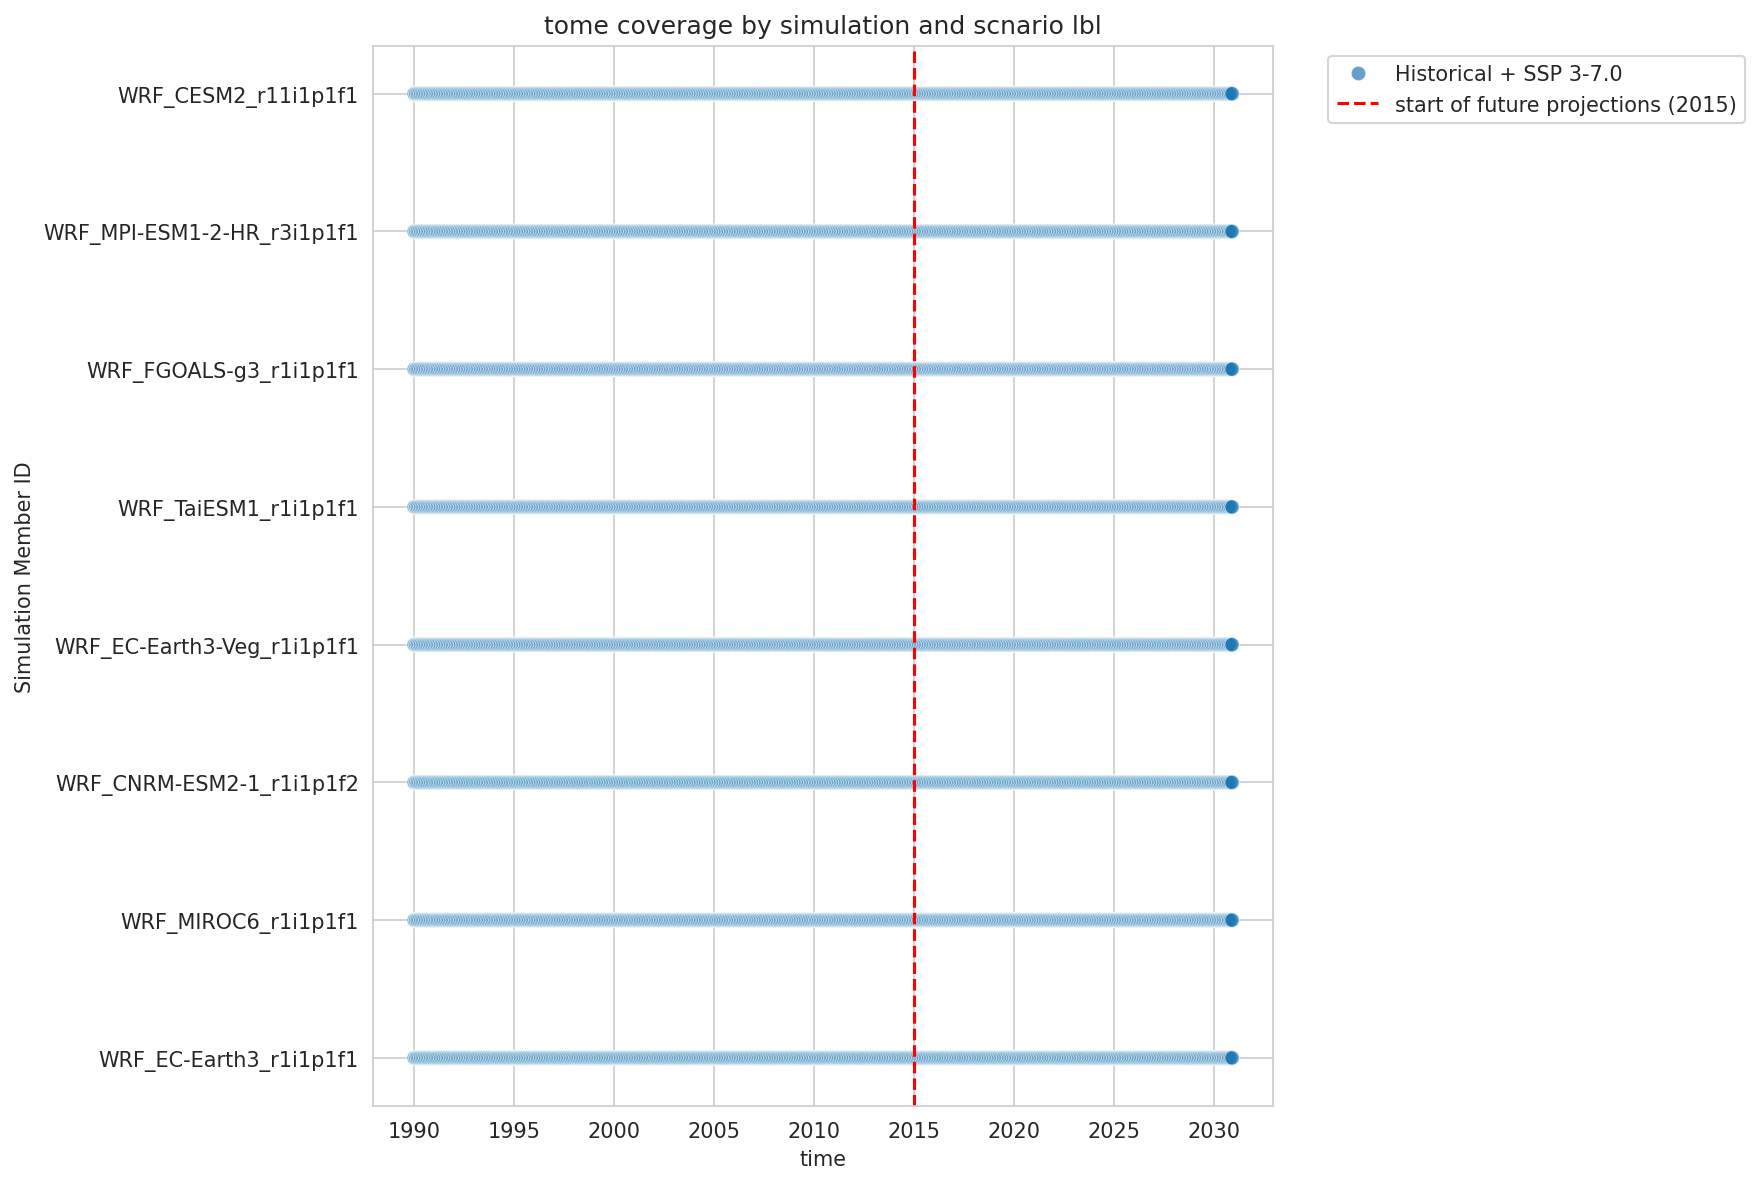

In [25]:
#cisuals for Scenario/Simulation Time Coverage (Diagnostic)
#    first available variable as a proxy to understand the time coverage
refre4cneKay = next(iter(spatialAverageDataDictionary.keys()), None)
if refre4cneKay and spatialAverageDataDictionary[refre4cneKay] is not None:
    print(f"Visualizing time coverage using '{refre4cneKay}' data structure...")
    #comv to DatdfaFrame to visualize the coordinates -> (time, simulation, scenario)
    dataFrameStructure = spatialAverageDataDictionary[refre4cneKay].to_dataframe(name='value').reset_index()

    #plot
    plt.figure(figsize=(12, 8))

    #check if 'simulation' exists before trying to plot it on the y-axis
    if 'simulation' in dataFrameStructure.columns:
        sns.scatterplot(data=dataFrameStructure, x='time', y='simulation', hue='scenario', style='scenario', s=50, alpha=0.7)
        plt.ylabel("Simulation Member ID")
        plt.grid(True, axis='y')
    else:
        #fallback iff only one simulation
        sns.scatterplot(data=dataFrameStructure, x='time', y='scenario', hue='scenario', s=50)
        plt.ylabel("Scenario")

    plt.title("tome coverage by simulation and scnario lbl")

    #add vertical line for the start of future projections
    startOfFuture = pd.to_datetime(f"{historicalSimulationEndYear+1}-01-01")
    plt.axvline(startOfFuture, color='red', linestyle='--', label=f'start of future projections ({historicalSimulationEndYear+1})')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("spatial avg data not available for visualization.")

aggre data annually for temp...


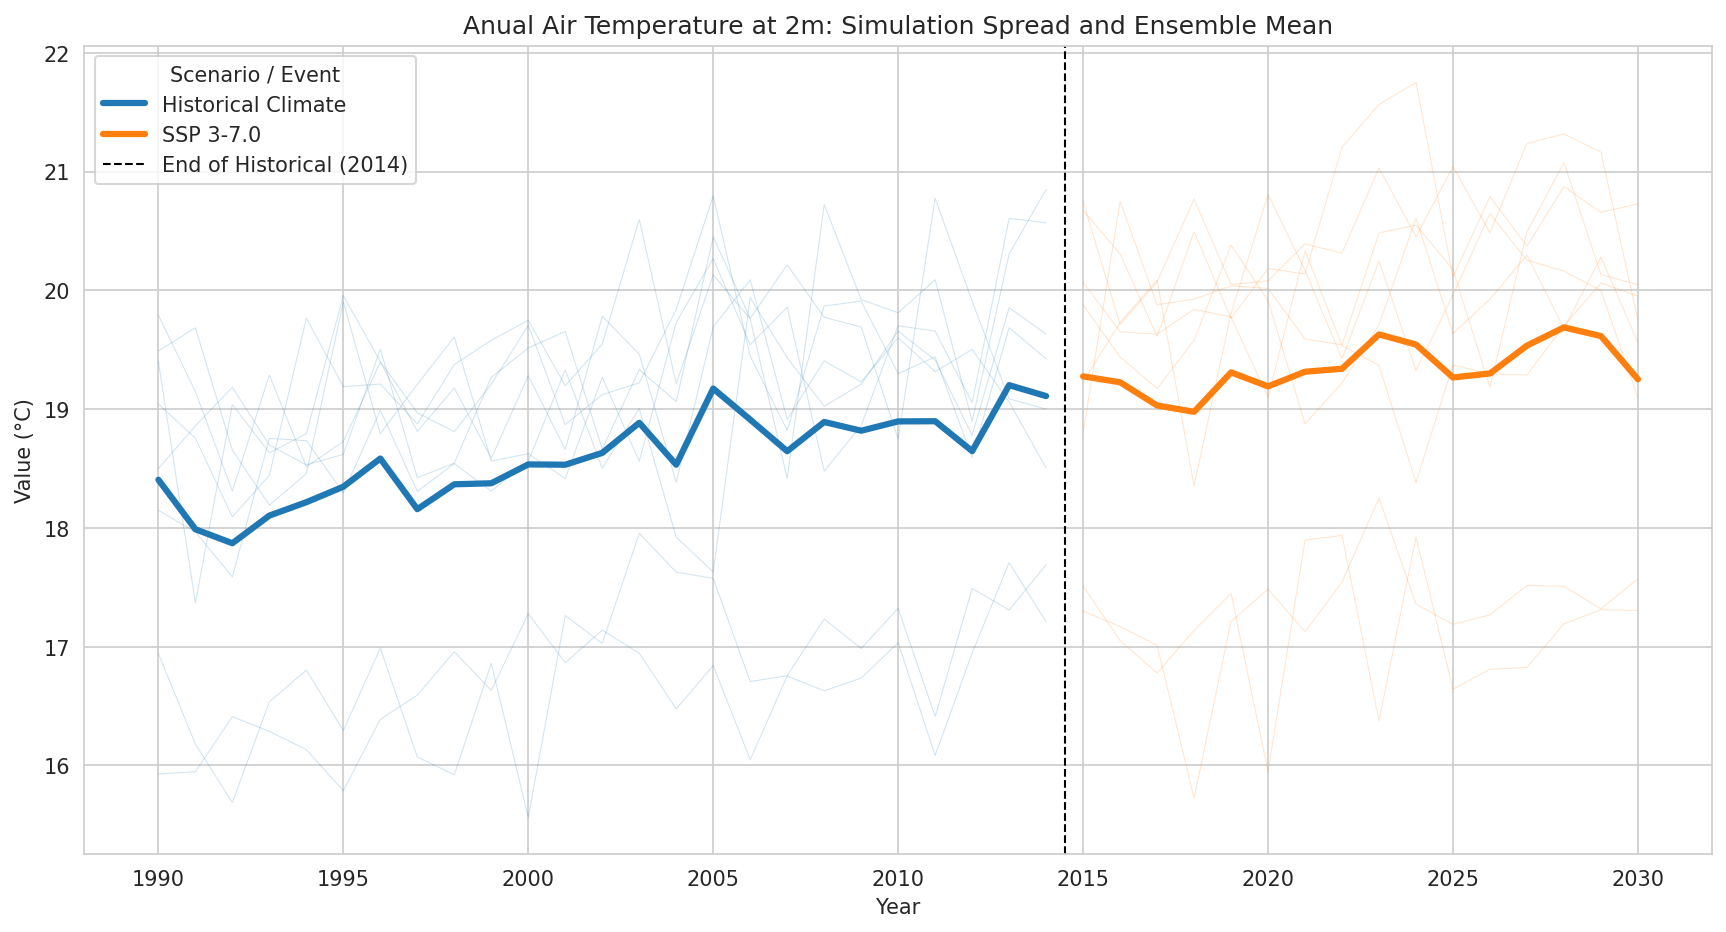

aggre data annually for precip...


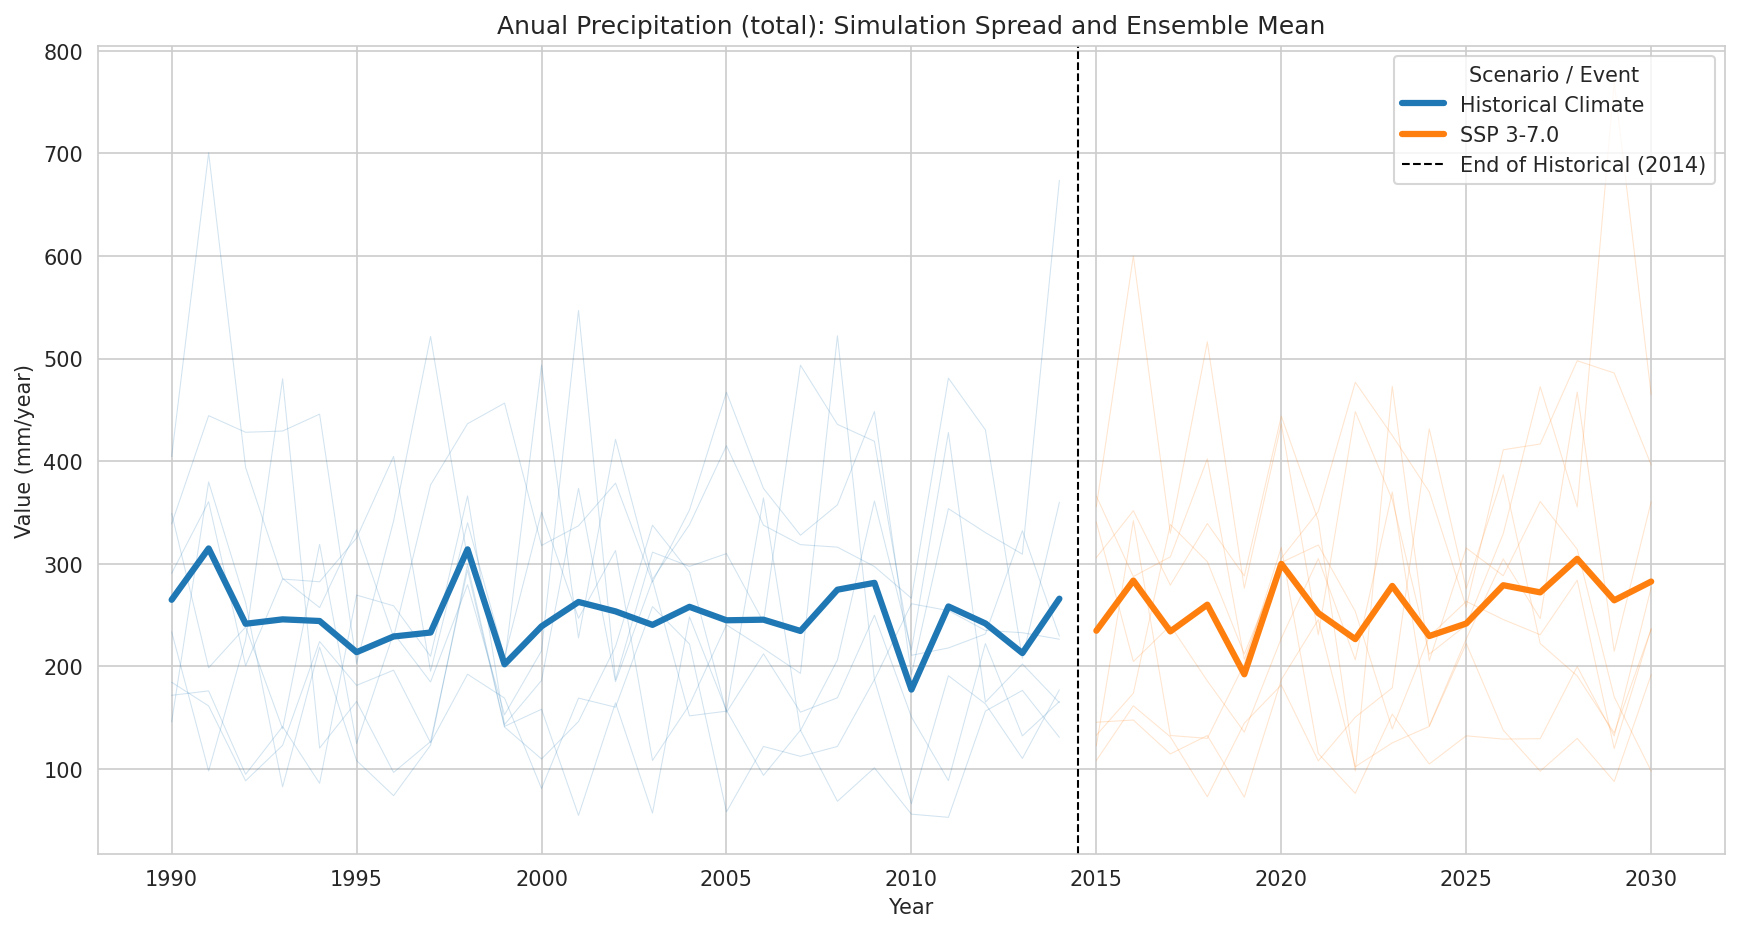

In [26]:
#cell 13 annual aggregation and TS visualisation
annualDataDictionary = {}
for key, monthlyData in spatialAverageDataDictionary.items():

    annualData = aggregateDataAnnually(monthlyData, key)
    if annualData is not None:
        annualDataDictionary[key] = annualData
        plotAnnualSpread(annualData, key)

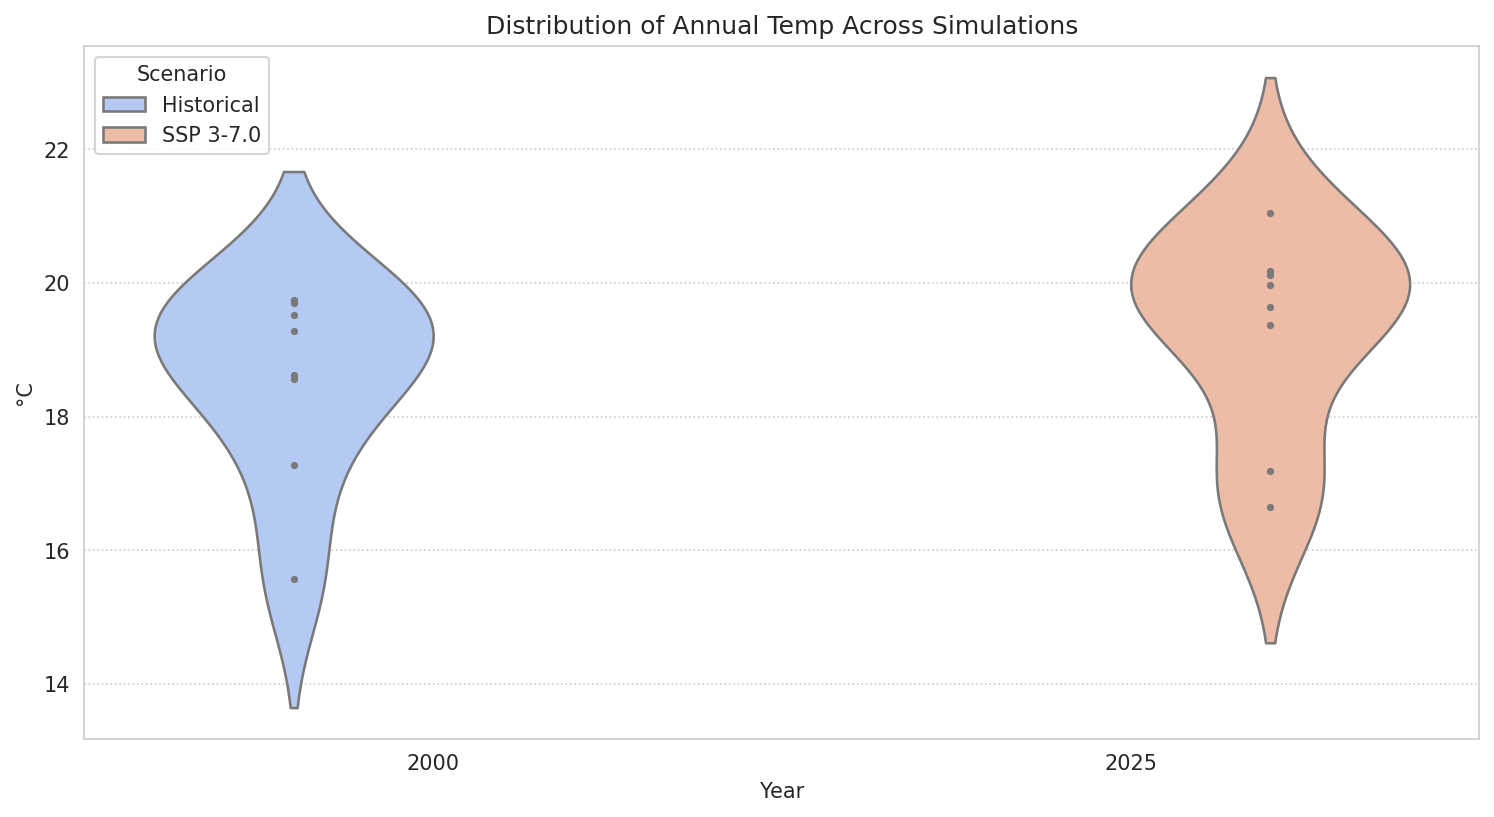

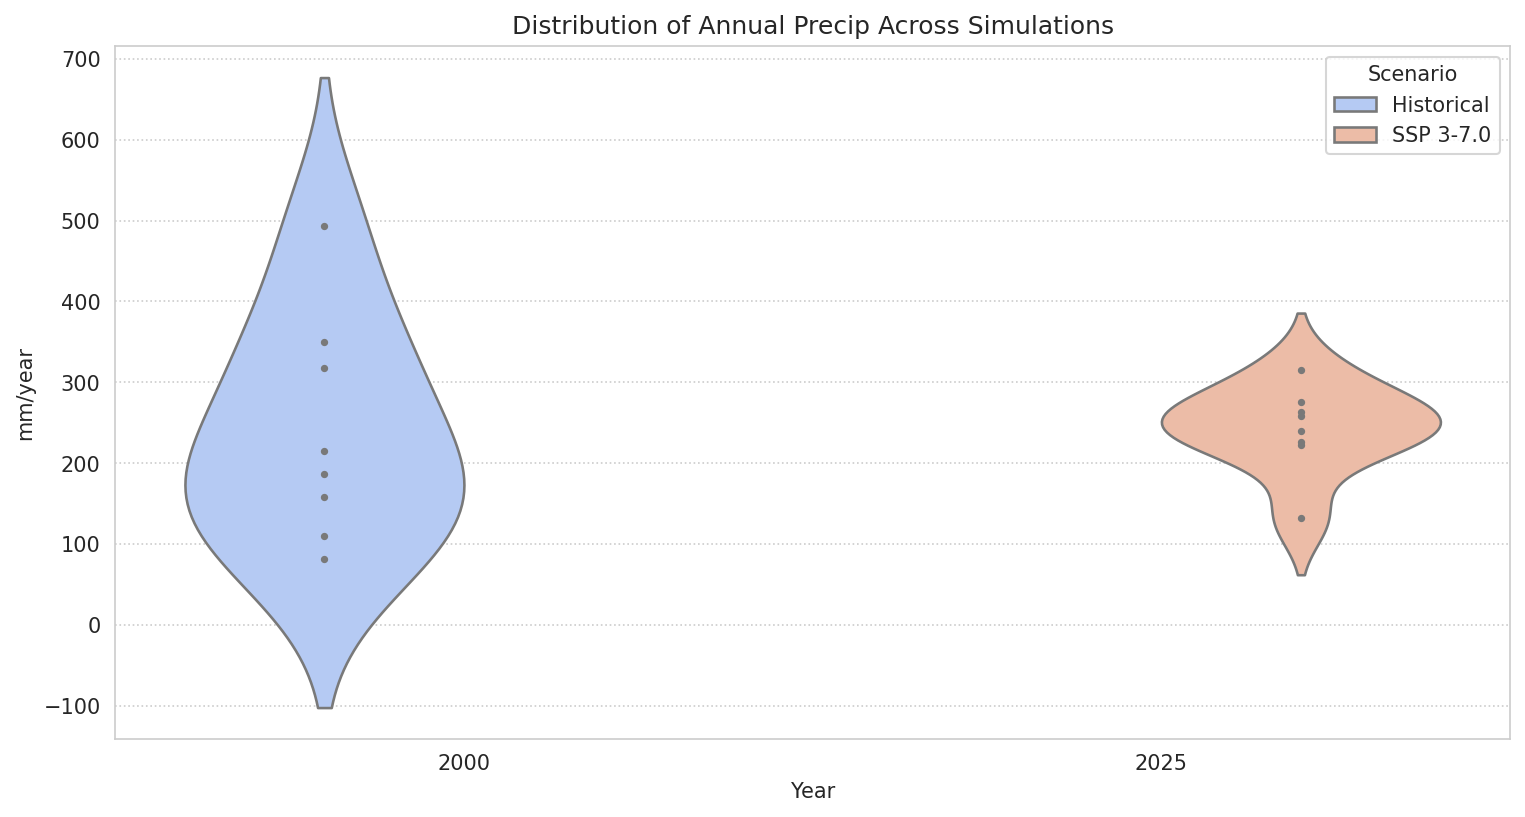

In [27]:
# dist anal using Violin Plots (Diagnostic)

yearsToCheckList = [2000, 2025]
if 'temp' in annualDataDictionary:
    plotSimulationDistribution(annualDataDictionary['temp'], 'temp', yearsToCheckList)

if 'precip' in annualDataDictionary:
    plotSimulationDistribution(annualDataDictionary['precip'], 'precip', yearsToCheckList)

plot seasonal comparison for temp...


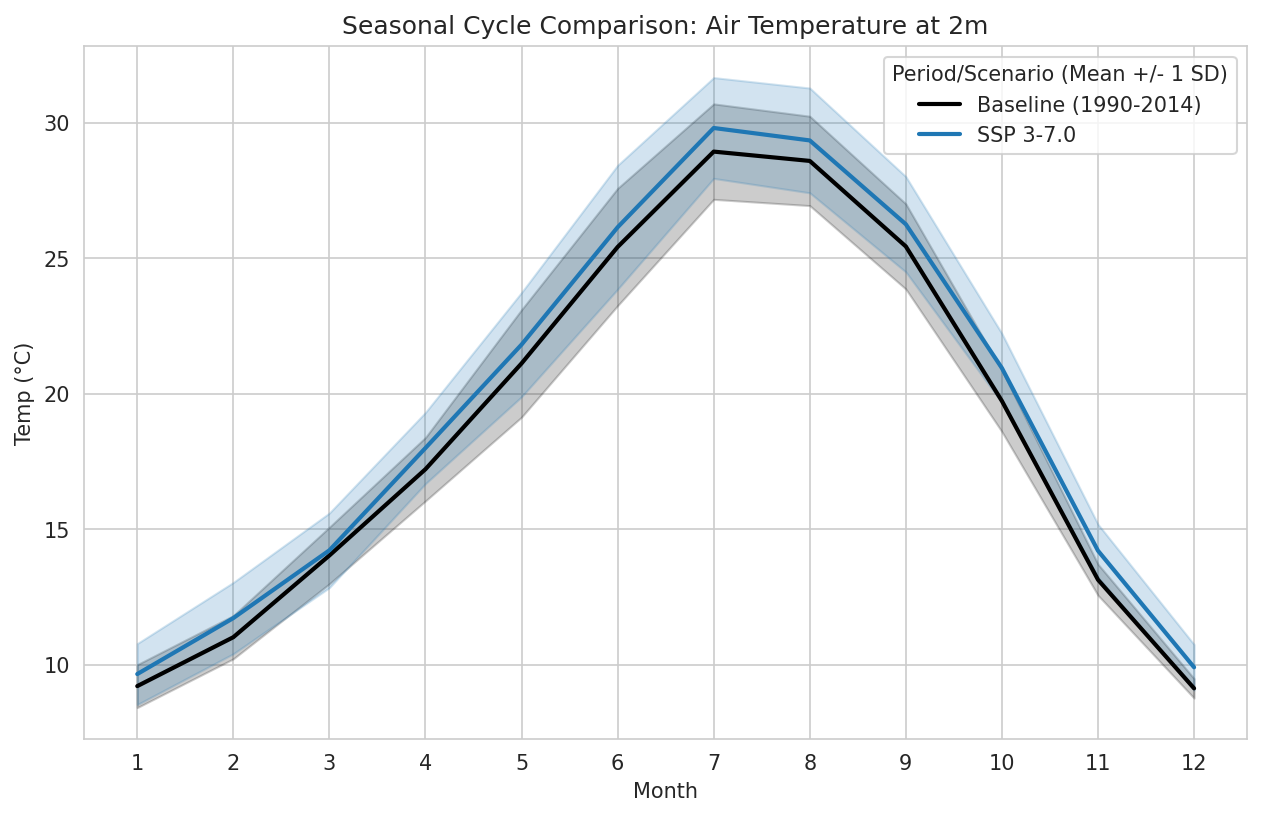

plot seasonal comparison for precip...


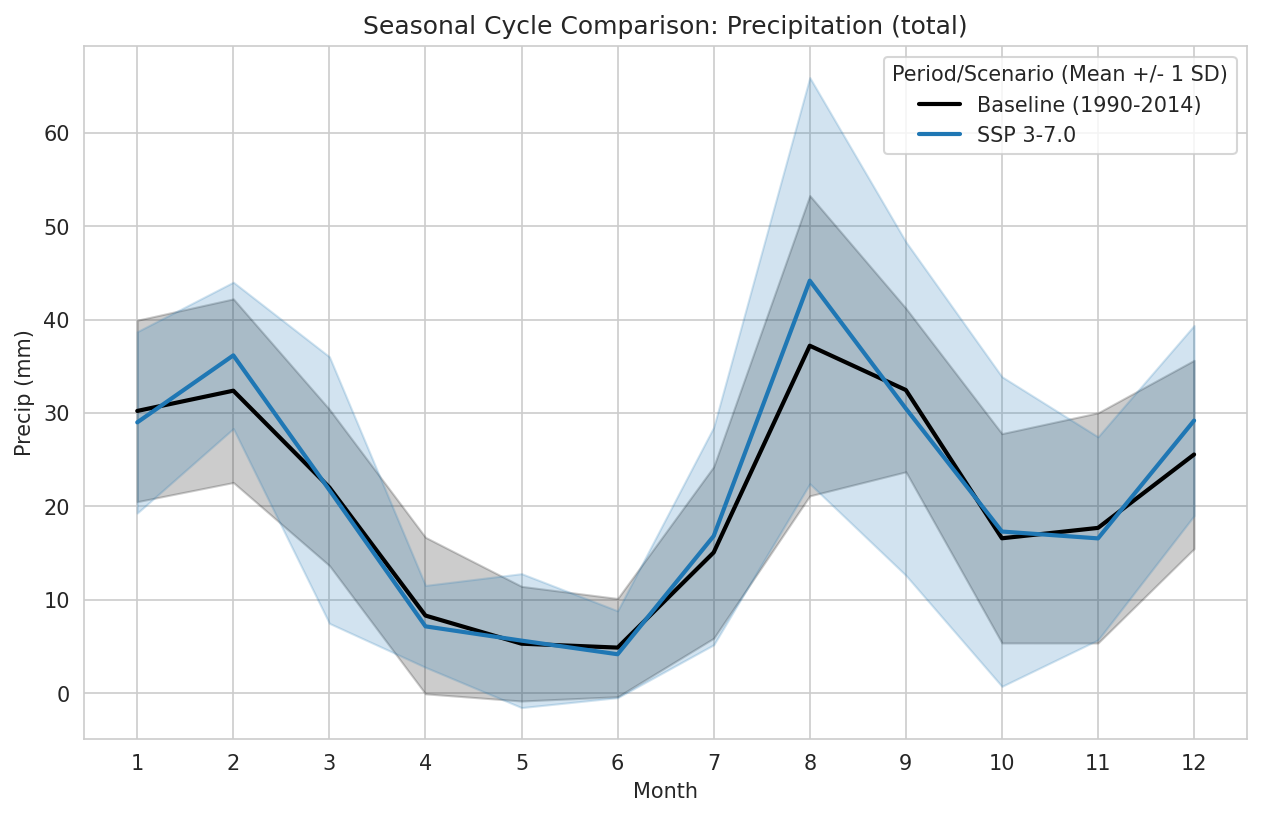

In [28]:
#temporal diagnostics, seasonality & diagnostic
    #uses monthly diags, seasonability & diagnostic
if 'temp' in spatialAverageDataDictionary:
    plotSeasonalComparison(spatialAverageDataDictionary, 'temp')

if 'precip' in spatialAverageDataDictionary:
    plotSeasonalComparison(spatialAverageDataDictionary, 'precip')

Analyzing spatial variability for temp...


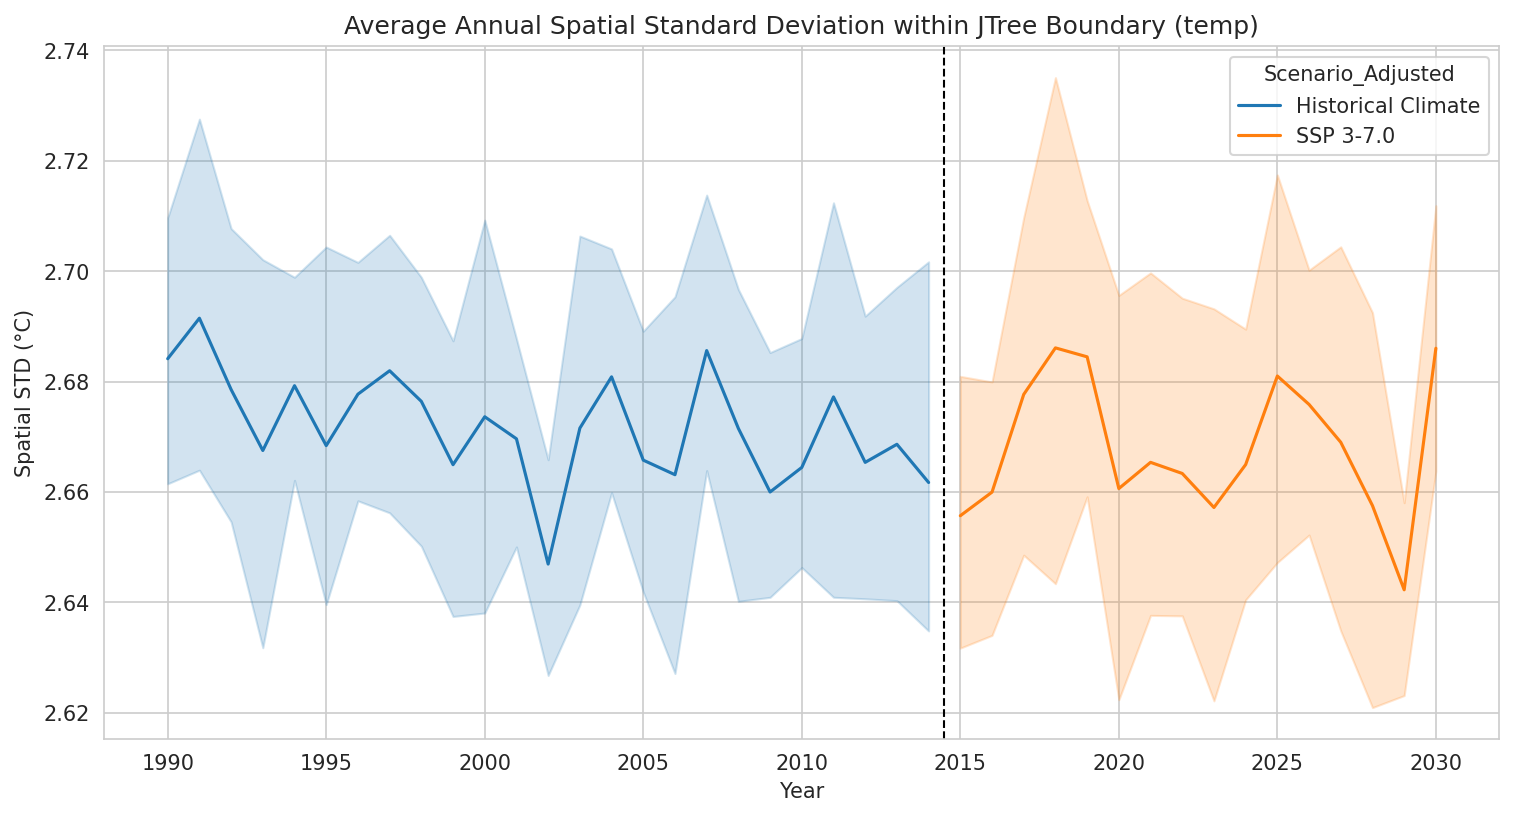

Analyzing spatial variability for precip...


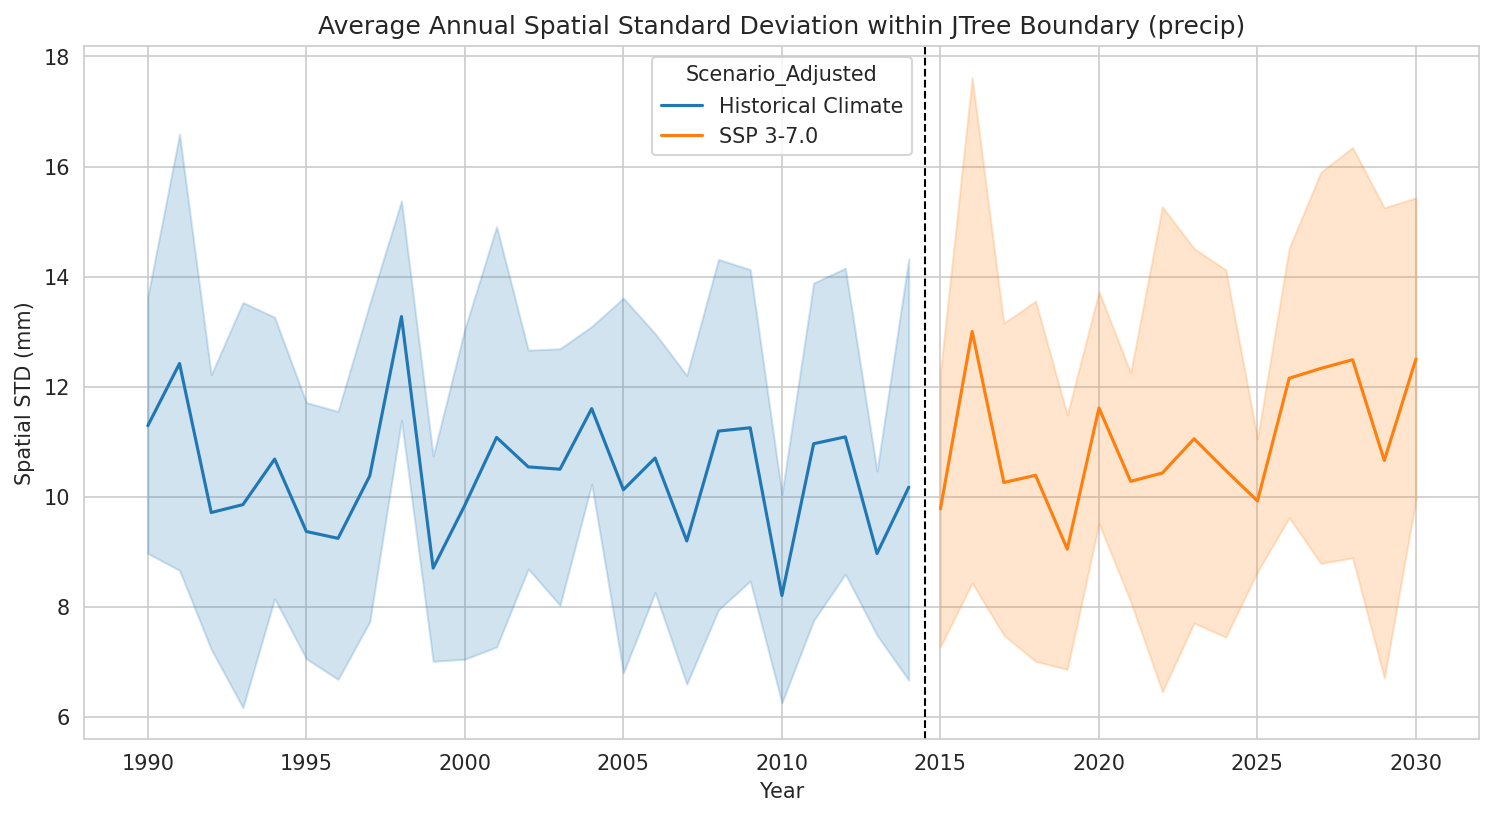

In [29]:

#spatial variability analysis (diagnostic)
  #analyzing how much spatial variation exists within the boundary over tiem
# We use the processed (masked) data here, not the spatially averaged data
if 'temp' in processedDiagnosticData and processedDiagnosticData['temp'] is not None:
  analyzeSpatialVariability(processedDiagnosticData['temp'], 'temp')

if 'precip' in processedDiagnosticData and processedDiagnosticData['precip'] is not None:
  analyzeSpatialVariability(processedDiagnosticData['precip'], 'precip')


In [30]:



#defining the param sapce for tests and availabiltiy check  
    #configs for param space for tests and availability cheque

print(f"Variables: {list(analysisVariablesDictionary.keys())}")
print(f"Scenarios: {testScenariosList}")
print(f"Resolutions: {testResolutionsList}")
print(f"Historical Test Year: {testTimeSliceHistorical[0]}")
print(f"Future Test Year: {testTimeSliceFuture[0]}")

print(f"\nTesting Bounds (JTree Area): Lat {jtreeLatitudeSlice}, Lon {jtreeLongitudeSlice}")

Variables: ['temp', 'precip']
Scenarios: ['Historical Climate', 'SSP 1-2.6', 'SSP 2-4.5', 'SSP 3-7.0', 'SSP 5-8.5']
Resolutions: ['3 km', '6 km', '45 km']
Historical Test Year: 1990
Future Test Year: 2050

Testing Bounds (JTree Area): Lat (np.float64(33.67018975804256), np.float64(34.129346624363556)), Lon (np.float64(-116.4580411520462), np.float64(-115.26220149792678))


In [31]:
#queryign availability Check
if jtreeLatitudeSlice is None or jtreeLongitudeSlice is None:
      print("Can't do testing since some data is missin, rerun cells or so iff soemthing is wrong.")
else:
    availabilityTestResults = []
    #itr across all combos
    for resolution in testResolutionsList:
        for scenario in testScenariosList:
            #adj time slice based on scenario type
            if scenario == "Historical Climate":
                currentTimeSlice= testTimeSliceHistorical
            else:
                currentTimeSlice = testTimeSliceFuture

            for key, variableName in analysisVariablesDictionary.items():
                print(f"Testing: {resolution}, {scenario}, {key} @ {currentTimeSlice}...")
                testStatus = "Success"; testDetails = ""; simulationCount = 0

                try:
                    #tro to get dxata
                    data = get_data(
                        variable=variableName, resolution=resolution, timescale="monthly",
                        scenario=[scenario], time_slice=currentTimeSlice,
                        latitude=jtreeLatitudeSlice, longitude=jtreeLongitudeSlice
                    )

                    #checl
                    if data is None:
                        testStatus = "Failure"
                        testDetails = "get_data returned None (Likely spatial coverage issue)."
                    elif data.time.size == 0:
                        testStatus = "Failure"
                        testDetails = "DataArray returned but is empty."
                    else:
                        # worked !
                        simulationCount = data.sizes.get('simulation', 1)
                        del data

                except Exception as e:
                    #handler for exceptiosn thrown
                    testStatus = "Error"
                    errorString = str(e)
                    if "is not a valid option" in errorString or " data found for your input values" in errorString:
                        testDetails = f"Exception: Combination not supported in catalog."
                    else:
                        testDetails = f"Exception: {errorString[:100]}.."

                #record the result
                availabilityTestResults.append({
                    "Resolution": resolution, "Scenario": scenario, "Variable": key,
                    "Status": testStatus, "Simulations Available": simulationCount, "Details": testDetails
                })
                print(f"   Result: {testStatus} (Sims: {simulationCount})")

    print("\nData retrieval test complete.")
    resultsDataFrame = pd.DataFrame(availabilityTestResults)

Testing: 3 km, Historical Climate, temp @ (1990, 1990)...


   Result: Success (Sims: 8)
Testing: 3 km, Historical Climate, precip @ (1990, 1990)...
   Result: Success (Sims: 8)
Testing: 3 km, SSP 1-2.6, temp @ (2050, 2050)...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testing: 3 km, SSP 1-2.6, precip @ (2050, 2050)...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testing: 3 km, SSP 2-4.5, temp @ (2050, 2050)...
ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testing: 3 km, SSP 2-4.5, precip @ (2050, 2050)...
ERROR: No data found for

In [32]:
#tabualting and visualing the restults, availability check
if 'resultsDataFrame' in globals() and not resultsDataFrame.empty:
    #ensure resoltuion is ordered correctly
    resultsDataFrame['Resolution'] = pd.Categorical(resultsDataFrame['Resolution'], categories=testResolutionsList, ordered=True)
    #make pivot table summarizing the 
    availabilityPivotTable = resultsDataFrame.pivot_table(index='Resolution',columns='Scenario',
        values='Status',
        aggfunc=aggregateAvailabilityStatus )
    #display colour table
    display(availabilityPivotTable.style.applymap(styleAvailabilityPivot))

    #view failures/errors
    failuresDataFrame = resultsDataFrame[resultsDataFrame['Status'] != "Success"]
    if not failuresDataFrame.empty:
        display(failuresDataFrame[['Resolution', 'Scenario', 'Variable', 'Status', 'Details']])
    else:
        print("\nAll combos possible detected. All combinations are available.")
else:
    print("No results data to tabulate. Please run Cell 17.")

Scenario,Historical Climate,SSP 1-2.6,SSP 2-4.5,SSP 3-7.0,SSP 5-8.5
Resolution,,,,,
3 km,Available,Unavailable,Unavailable,Available,Unavailable
6 km,Unavailable,Unavailable,Unavailable,Unavailable,Unavailable
45 km,Available,Available,Available,Available,Available


,Resolution,Scenario,Variable,Status,Details
2,3 km,SSP 1-2.6,temp,Failure,get_data returned None (Likely spatial coverag...
3,3 km,SSP 1-2.6,precip,Failure,get_data returned None (Likely spatial coverag...
4,3 km,SSP 2-4.5,temp,Failure,get_data returned None (Likely spatial coverag...
5,3 km,SSP 2-4.5,precip,Failure,get_data returned None (Likely spatial coverag...
8,3 km,SSP 5-8.5,temp,Failure,get_data returned None (Likely spatial coverag...
9,3 km,SSP 5-8.5,precip,Failure,get_data returned None (Likely spatial coverag...
10,6 km,Historical Climate,temp,Error,Exception: '6 km'..
11,6 km,Historical Climate,precip,Error,Exception: '6 km'..
12,6 km,SSP 1-2.6,temp,Error,Exception: '6 km'..
13,6 km,SSP 1-2.6,precip,Error,Exception: '6 km'..


original bounds: Lat (np.float64(33.67018975804256), np.float64(34.129346624363556)), Lon (np.float64(-116.4580411520462), np.float64(-115.26220149792678))
expanded bounds (Buffer 0.2°): Lat (np.float64(33.47), np.float64(34.329)), Lon (np.float64(-116.658), np.float64(-115.062))


/tmp/ipykernel_685/3153273302.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_685/3153273302.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


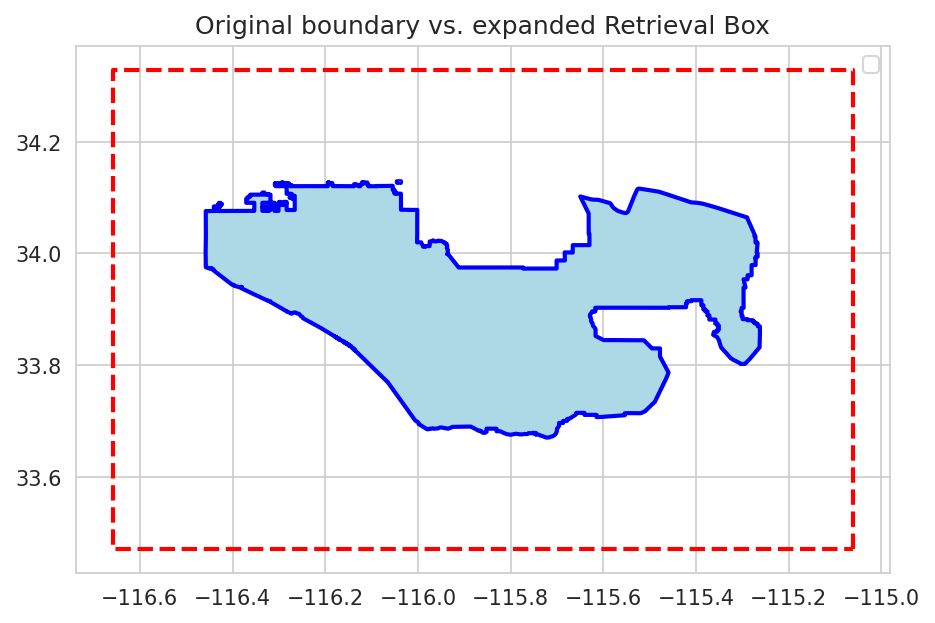

In [33]:
#hoping that expanding box will resolve issues of bondary being on edge of data coverage
BUFFER_DEGREES = 0.2
expandedLatitudeSlice = (round(jtreeLatitudeSlice[0] - BUFFER_DEGREES, 3),
    round(jtreeLatitudeSlice[1] + BUFFER_DEGREES, 3))
expandedLongitudeSlice = (round(jtreeLongitudeSlice[0] - BUFFER_DEGREES, 3),
    round(jtreeLongitudeSlice[1] + BUFFER_DEGREES, 3))

print(f"original bounds: Lat {jtreeLatitudeSlice}, Lon {jtreeLongitudeSlice}")
print(f"expanded bounds (Buffer {BUFFER_DEGREES}°): Lat {expandedLatitudeSlice}, Lon {expandedLongitudeSlice}")

#vis the difference
if joshuaTreeBoundaryWgs84 is not None:
    fig,ax =plt.subplots(figsize=(7, 7))
    joshuaTreeBoundaryWgs84.plot(ax=ax, edgecolor="blue", facecolor="lightblue", linewidth=2, label="Original Boundary (Analysis Area)")
    #crate and plot expended bounding box
    expandedBoxGeometry = box(expandedLongitudeSlice[0], expandedLatitudeSlice[0],
 expandedLongitudeSlice[1], expandedLatitudeSlice[1])
    expandedGeoDataFrame = gpd.GeoDataFrame({'geometry': [expandedBoxGeometry]}, crs=standardCoordinateReferenceSystem)
    expandedGeoDataFrame.plot(ax=ax, edgecolor="red", linestyle="--", facecolor="none", linewidth=2, label="Expanded Retrieval Box")

    plt.title("Original boundary vs. expanded Retrieval Box")
    plt.legend()
    plt.show()

In [ ]:

#executoin
if 'resultsDataFrame' in globals() and not resultsDataFrame.empty:
    #get combos which have previously specifically failed @ 3 km
    failedCombinations3km = resultsDataFrame[
        (resultsDataFrame['Status'] != "Success") & (resultsDataFrame['Resolution'] == "3 km")]
    if failedCombinations3km.empty:
        print("\nNo failures detected with 3km")
    else:
        print("\trying prev failed 3 km combinations w/ expanded bounds")
        remediationResultsList =[]
        for index,row in failedCombinations3km.iterrows():
            scenario = row['Scenario']; key = row['Variable']
            variableName = analysisVariablesDictionary[key]

            currentTimeSlice = testTimeSliceHistorical if scenario == "Historical Climate" else testTimeSliceFuture
            print(f"retest: {scenario}, {key}...")
            remediationStatus = "failed (expanded)"; simulationCount = 0
            try:
                #attempt retrevial w/ expended boundaries
                data = get_data(
                    variable=variableName, resolution="3 km", timescale="monthly", scenario=[scenario],time_slice=currentTimeSlice,
                    latitude=expandedLatitudeSlice, longitude=expandedLongitudeSlice)
                if data is not None and data.time.size > 0:
                    print("   data was gotten w/ expanded box. Coverage verification happening  after masking...")
                    #mask teh retretived data w/ the original boundary
                    if joshuaTreeBoundaryWgs84 is not None:
                        maskedData = maskDataArrayToBoundary(data, joshuaTreeBoundaryWgs84)

                        #check iff the masked data covering actual JTree area is entirely NaN
                        sampleSlice = maskedData.isel(time=0).squeeze(drop=True)
                        if 'simulation' in sampleSlice.dims:
                            sampleSlice = sampleSlice.isel(simulation=0).squeeze(drop=True)
                        sampleSlice.load()

                        if sampleSlice.isnull().all():
                            remediationStatus = "failed since (No Overlap)"
                            print("   rezz: retretieved data actually does not overlap with JTree boundary.")
                        else:
                            remediationStatus = "Success expanded"
                            simulationCount = data.sizes.get('simulation', 1)
                            print(f"   rezz: yay! (Sims: {simulationCount})")
                        del data, maskedData, sampleSlice
                    else:
                         print("   rezz: Success but overlap unverified (boundary missing).")
                         remediationStatus = "Success (Expanded, Unverified)"
                         del data
                else:
                    print("   rezz: Still returning None or empty data.")

            except Exception as e:
                remediationStatus = "Errror (Expanded)"; print(f"   Result: Error: {e}")

            remediationResultsList.append({"Scenario": scenario, "Variable": key, "Status": remediationStatus, "Simulations": simulationCount})

        #display results
        print("\n checking remediation attempt 1 Results w/ Expanded Box")
        if remediationResultsList:
            remediationDataFrame = pd.DataFrame(remediationResultsList)
            display(remediationDataFrame)

            # Conclusion
            successStatuses = ["(Expanded)", "(Expanded, Unverified)"]
            if any(status in remediationDataFrame['Status'].values for status in successStatuses):
                 print("\n action required; update the main analysis notebooks to use the expanded bounds for data retrieval & rely on masking.")
            else:
                print("\n expanding box did not mitigate this problem :((")
        else:
            print("no remediation attempts were made.")
else:
    print("results data frame not available for remediation, try reuning line 17")

	rying prev failed 3 km combinations w/ expanded bounds
retest: SSP 1-2.6, temp...


Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Still returning None or empty data.
retest: SSP 1-2.6, precip...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Still returning None or empty data.
retest: SSP 2-4.5, temp...
ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Still returning None or empty data.
retest: SSP 2-4.5, precip...
ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Still returning None or empty data.
retest: SSP 5-8.5, temp...
ERROR: No data found for your input 

,Scenario,Variable,Status,Simulations
0,SSP 1-2.6,temp,failed (expanded),0
1,SSP 1-2.6,precip,failed (expanded),0
2,SSP 2-4.5,temp,failed (expanded),0
3,SSP 2-4.5,precip,failed (expanded),0
4,SSP 5-8.5,temp,failed (expanded),0
5,SSP 5-8.5,precip,failed (expanded),0



 expanding box did not mitigate this problem :((


In [35]:
#cell 21 remediation strategy 2 which analyzing coarser rezzies and final reccomendation
if 'availabilityPivotTable' in globals():
    try:
        #identify which coarser resoltions were tests
        coarseResolutionsToCheck = [res for res in ["6 km", "45 km"] if res in availabilityPivotTable.index]
        if coarseResolutionsToCheck:
            coarseAvailability = availabilityPivotTable.loc[coarseResolutionsToCheck]
            display(coarseAvailability.style.applymap(styleAvailabilityPivot))

            #interp guidance and recommendations

            #  3km availability
            is3kmAvailable = True
            if "3 km" in availabilityPivotTable.index and "Unavailable" in availabilityPivotTable.loc["3 km"].values:
                is3kmAvailable = False

            if is3kmAvailable:
                print("1. 3 km data appears available for the tested scenarios. Proceed with 3 km resolution.")
            else:
                 #check iff the expanded box strategy (Cell 20) was successful
                 expandedBoxSuccess = False
                 successStatuses = ["Success (Expanded)", "Success (Expanded, Unverified)"]
                 if 'remediationDataFrame' in globals() and any(status in remediationDataFrame['Status'].values for status in successStatuses):
                    expandedBoxSuccess = True

                 if expandedBoxSuccess:
                     print("bounding box expansion worked")
                 else:
                    # If 3km is not viable, recommend alternatives
                    print("3lm ain't in anything except 3.70 look to see iff this is expected within caladapt")
            print("\n2. For Data Processing:")
            print("   - unit conversions and spatial masking/weighting  worked orrectly.")

        else:
             print("no coarser resolutions  tested.")

    except Exception as e:
        print(f"error analyzing coarser resolutions: {e}")
else:
    print("avalaible pivot table not generated, check cell 18.")

Scenario,Historical Climate,SSP 1-2.6,SSP 2-4.5,SSP 3-7.0,SSP 5-8.5
Resolution,,,,,
6 km,Unavailable,Unavailable,Unavailable,Unavailable,Unavailable
45 km,Available,Available,Available,Available,Available


3lm ain't in anything except 3.70 look to see iff this is expected within caladapt

2. For Data Processing:
   - unit conversions and spatial masking/weighting  worked orrectly.


Updated Test Resolutions: ['3 km', '9 km', '45 km']
	rying t to load Mojave boundary from: ../Mojave/Mojave_National_Preserve.shp
Reprojecting Mojave boundary to WGS84...
Mojave Boundary Loaded. Bounds: Lat (np.float64(34.71693048361919), np.float64(35.59077455259237)), Lon (np.float64(-116.16503220167623), np.float64(-114.94916062294271))


/tmp/ipykernel_685/3752081132.py:34: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_685/3752081132.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


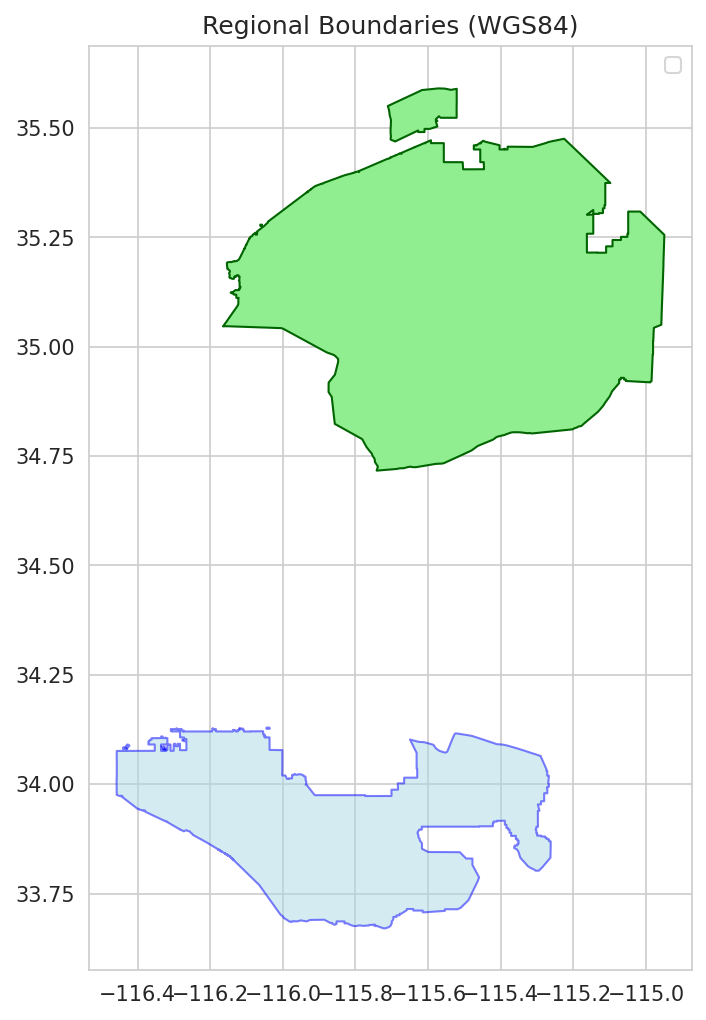

In [36]:
#now loading in and checkign wiht Mojava
testResolutionsListUpdated = ["3 km", "9 km",   "45 km"]
print(f"Updated Test Resolutions: {testResolutionsListUpdated}")
#init vars
mojaveBoundaryWgs84 =None
mojaveLongitudeSlice= None
mojaveLatitudeSlice = None

#loading the Mojave shapefile (Path defined in Cell 1)
print(f"\trying t to load Mojave boundary from: {mojaveShapeRelativePath}")
try:
    mojaveBoundaryWgs84 = gpd.read_file(mojaveShapeRelativePath)

    #ensruing CRS is WGS84 standardCoordinateReferenceSystem def in Cell 2
    if mojaveBoundaryWgs84.crs is None:
        mojaveBoundaryWgs84.set_crs(standardCoordinateReferenceSystem, inplace=True)
    elif str(mojaveBoundaryWgs84.crs) != standardCoordinateReferenceSystem:
        print("Reprojecting Mojave boundary to WGS84...")
        mojaveBoundaryWgs84 = mojaveBoundaryWgs84.to_crs(standardCoordinateReferenceSystem)

    boundaryBoundsMojave = mojaveBoundaryWgs84.total_bounds
    mojaveLongitudeSlice = (boundaryBoundsMojave[0], boundaryBoundsMojave[2])
    mojaveLatitudeSlice = (boundaryBoundsMojave[1], boundaryBoundsMojave[3])
    print(f"Mojave Boundary Loaded. Bounds: Lat {mojaveLatitudeSlice}, Lon {mojaveLongitudeSlice}")

    #vis  boundary
    fig, ax = plt.subplots(figsize=(8,8))
    mojaveBoundaryWgs84.plot(ax=ax, edgecolor="darkgreen", facecolor="lightgreen", label="Mojave NP")
    # Overlay JTree for context if available
    if 'joshuaTreeBoundaryWgs84' in globals() and joshuaTreeBoundaryWgs84 is not None:
        joshuaTreeBoundaryWgs84.plot(ax=ax, edgecolor="blue", facecolor="lightblue", alpha=0.5, label="JTree NP")

    plt.title("Regional Boundaries (WGS84)")
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Could not load shapefile from {mojaveShapeRelativePath}: {e}")
    # Define a fallback box if the shapefile fails (approximate Mojave area)
    mojaveLongitudeSlice = (-116.3, -115.0)
    mojaveLatitudeSlice = (34.8, 35.7)
    print(f"Using fallback bounding box: Lat {mojaveLatitudeSlice}, Lon {mojaveLongitudeSlice}")

In [37]:

if mojaveLatitudeSlice is None or mojaveLongitudeSlice is None:
      print("make sure mojave slice is defined")
else:
    print(f"\nsemantic retreival for mojave\n")

    availabilityTestResultsMojave = []
    #iterate over al in updated list
    for resolution in testResolutionsListUpdated:
        for scenario in testScenariosList:
            # Adjust time slice
            if scenario == "Historical Climate":
                currentTimeSlice = testTimeSliceHistorical
            else:
                currentTimeSlice = testTimeSliceFuture

            for key, variableName in analysisVariablesDictionary.items():
                print(f"Testitestingng Mojave: {resolution}, {scenario}, {key}...")

                testStatus = "Success"; testDetails = ""; simulationCount = 0

                try:
                    #
                    data = get_data(
                        variable=variableName, resolution=resolution, timescale="monthly",
                        scenario=[scenario], time_slice=currentTimeSlice,
                        latitude=mojaveLatitudeSlice, longitude=mojaveLongitudeSlice
                    )

                    
                    if data is None:
                        testStatus = "Failure"
                        testDetails = "get_data returned None (Likely spatial coverage issue)."
                    elif data.time.size == 0:
                        testStatus = "Failure"
                        testDetails = "DataArray returned but is empty."
                    else:
                        #yay
                        simulationCount = data.sizes.get('simulation', 1)
                        del data

                except Exception as e:
                    #handler
                    testStatus = "Error"
                    errorString = str(e)
                    if "is not a valid option" in errorString or "No data found for your input values" in errorString:
                        testDetails = f"Exception: Combination not supported in catalog."
                    elif "invalid resolution" in errorString:
                         testDetails = f"Exception: Resolution '{resolution}' not supported."
                    else:
                        testDetails = f"Exception: {errorString[:100]}..."

                # record  result
                availabilityTestResultsMojave.append({
                    "Resolution": resolution, "Scenario": scenario, "Variable": key,
                    "Status": testStatus, "Simulations Available": simulationCount, "Details": testDetails
                })
                print(f"   Result: {testStatus} (Sims: {simulationCount})")

    
    resultsDataFrameMojave = pd.DataFrame(availabilityTestResultsMojave)


semantic retreival for mojave

Testitestingng Mojave: 3 km, Historical Climate, temp...
   Result: Success (Sims: 8)
Testitestingng Mojave: 3 km, Historical Climate, precip...
   Result: Success (Sims: 8)
Testitestingng Mojave: 3 km, SSP 1-2.6, temp...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testitestingng Mojave: 3 km, SSP 1-2.6, precip...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testitestingng Mojave: 3 km, SSP 2-4.5, temp...
ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure 

In [38]:
#.Visualization (JTree vs. Mojave)

try:
    from IPython.display import display
except ImportError:
    display = print

#check if both dfs exist
if 'resultsDataFrame' in globals() and 'resultsDataFrameMojave' in globals():
    # Prepare JTree data (Clean up the previous run)
    #out filgtrer out 6 from when i read it upside down
    jtreeComparisonDataFrame =  resultsDataFrame[resultsDataFrame['Resolution'] != '6 km'].copy()
    jtreeComparisonDataFrame['Region'] ='Joshua Tree'

    #prepare Mojave data
    mojaveComparisonDataFrame = resultsDataFrameMojave.copy()
    mojaveComparisonDataFrame['Region'] = 'Mojave'

    #combine  rezzy
    combinedResultsDataFrame =pd.concat([jtreeComparisonDataFrame, mojaveComparisonDataFrame])

    
    
    #try resolutions in order of 3, 9 45
    try:
        # Sort numerically based on the integer part of the resolution string
        presentResolutions = sorted(list(combinedResultsDataFrame['Resolution'].unique()), key=lambda x: int(x.split()[0]))
    except ValueError:
        #fallack sort if parsing fails
        presentResolutions = sorted(list(combinedResultsDataFrame['Resolution'].unique()))

    combinedResultsDataFrame['Resolution'] = pd.Categorical(combinedResultsDataFrame['Resolution'], categories=presentResolutions, ordered=True)

    #create the comparative pivot table
    # by Region and Resolution for side by side comparison
    comparativePivotTable = combinedResultsDataFrame.pivot_table(index=['Region', 'Resolution'],
        columns='Scenario',values='Status',aggfunc=aggregateAvailabilityStatus)

    display(comparativePivotTable.style.applymap(styleAvailabilityPivot))
    try:
        jtree3km =comparativePivotTable.loc[('Joshua Tree', '3 km')]
        mojave3km = comparativePivotTable.loc[('Mojave', '3 km')]

        if jtree3km.equals(mojave3km):
            print("avalability between M adn Jtre is identiical")
        else:
            print("3km avlaiblility differes between the regeions.")

    except KeyError:
        
        print(" coudn't compare, try again")

else:
    print("Missing results dfs.")

avalability between M adn Jtre is identiical


In [ ]:
DOWNSCALING_METHODS_TO_TEST = ["Statistical", "Dynamical"]
testResolutionsListCorrected = ["3 km", "9 km", "45 km"]

if jtreeLatitudeSlice is None or jtreeLongitudeSlice is None:
      print("Spatial boundaries are not defined, try again.")
else:
    print(f"\starting  retrievial\n")

    availabilityTestResults = []
    # #iter over all possibel combos
    for downscalingMethod in DOWNSCALING_METHODS_TO_TEST:
        for resolution in testResolutionsListCorrected:
            for scenario in testScenariosList:
                #adjust time slice based on waht scenario we're in 
                if scenario =="Historical Climate":
                    currentTimeSlice = testTimeSliceHistorical
                else:
                    currentTimeSlice = testTimeSliceFuture

                for key, variableName in analysisVariablesDictionary.items():
                    print(f"Testing: {downscalingMethod}, {resolution}, {scenario}, {key}...")

                    testStatus = "Success"; testDetails = ""; simulationCount = 0

                    try:
                        # w/ downascaling
                        data = get_data(
                            variable=variableName,
                            resolution=resolution,
                            timescale="monthly",
                            scenario=[scenario],
                            time_slice=currentTimeSlice,
                            latitude=jtreeLatitudeSlice,
                            longitude=jtreeLongitudeSlice,
                            downscaling_method=downscalingMethod #idterate though both of these to Get LOCA and WFR
                        )

                        # check rezzy
                        if data is None:
                            testStatus = "Failure"
                            testDetails = "get_data returned None (Likely spatial coverage issue)."
                        elif data.time.size == 0:
                            testStatus = "Failure"
                            testDetails = "DataArray returned but is empty."
                        else:
                            # Success
                            simulationCount = data.sizes.get('simulation', 1)
                            del data

                    except Exception as e:
                       #Exception handling important here as we weant to see iff something is just not avaliable
                        testStatus = "Error"
                        errorString = str(e)
                        # These errors usually mean the combination (e.g., 9km Statistical) is invalid
                        if "is not a valid option" in errorString or "No data found for your input values" in errorString:
                            testDetails = f"Exception: Combination not supported in catalog."
                        elif "invalid resolution" in errorString:
                             testDetails = f"Exception: Resolution '{resolution}' not supported for this method."
                        else:
                            testDetails = f"Exception: {errorString[:100]}..."

                    #record results
                    availabilityTestResults.append({
                        "Method": downscalingMethod,
                        "Resolution": resolution,
                        "Scenario": scenario,
                        "Variable": key,
                        "Status": testStatus,
                        "Simulations Available": simulationCount,
                        "Details": testDetails
                    })
                    print(f"   Result: {testStatus} (Sims: {simulationCount})")

    print("\nData retrieval test complete.")
    #overwreite the previous resultsDataFrame with this comprehensive one
    resultsDataFrame = pd.DataFrame(availabilityTestResults)


Starting systematic data retrieval test (Explicit Downscaling)...

Testing: Statistical, 3 km, Historical Climate, temp...
ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testing: Statistical, 3 km, Historical Climate, precip...
   Result: Success (Sims: 70)
Testing: Statistical, 3 km, SSP 1-2.6, temp...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
   Result: Failure (Sims: 0)
Testing: Statistical, 3 km, SSP 1-2.6, precip...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

   Result: Success (Sims: 34)
Testing: Statistical, 3 km, SSP 2-4.5, temp...
ERROR: No data found for your input values. Please modify your data request. 
R

In [ ]:
try:
    from IPython.display import display
except ImportError:
    display = print

if 'resultsDataFrame' in globals() and not resultsDataFrame.empty:
    #need to be ordered 3 9 45km 
    try:
        #sort numeric string
        presentResolutions = sorted(list(resultsDataFrame['Resolution'].unique()), key=lambda x: int(x.split()[0]))
    except ValueError:
        presentResolutions = sorted(list(resultsDataFrame['Resolution'].unique()))

    resultsDataFrame['Resolution'] = pd.Categorical(resultsDataFrame['Resolution'], categories=presentResolutions, ordered=True)

    #piv table based on avaliablility
    availabilityPivotTable = resultsDataFrame.pivot_table(
        index=['Method', 'Resolution'],
        columns='Scenario',
        values='Status',
        aggfunc=aggregateAvailabilityStatus #helper funciton from cell 4
    )

    print("Data abliabliltuy:")
    #disp
    display(availabilityPivotTable.style.applymap(styleAvailabilityPivot))

    # Detailed view of failures/errors
    failuresDataFrame = resultsDataFrame[resultsDataFrame['Status'] != "Success"]
    if not failuresDataFrame.empty:
        print("\n--- Detailed Failure Report ---")
        display(failuresDataFrame[['Method', 'Resolution', 'Scenario', 'Variable', 'Status', 'Details']])
    else:
        print("\nNo failures detected. All combinations are available.")
else:
    print("No results data to tabulate. Please run Cell 17.")

--- Data Availability Summary by Downscaling Method (Pooled Variables) ---



--- Detailed Failure Report ---


,Method,Resolution,Scenario,Variable,Status,Details
0,Statistical,3 km,Historical Climate,temp,Failure,get_data returned None (Likely spatial coverag...
2,Statistical,3 km,SSP 1-2.6,temp,Failure,get_data returned None (Likely spatial coverag...
4,Statistical,3 km,SSP 2-4.5,temp,Failure,get_data returned None (Likely spatial coverag...
6,Statistical,3 km,SSP 3-7.0,temp,Failure,get_data returned None (Likely spatial coverag...
8,Statistical,3 km,SSP 5-8.5,temp,Failure,get_data returned None (Likely spatial coverag...
10,Statistical,9 km,Historical Climate,temp,Failure,get_data returned None (Likely spatial coverag...
11,Statistical,9 km,Historical Climate,precip,Failure,get_data returned None (Likely spatial coverag...
12,Statistical,9 km,SSP 1-2.6,temp,Failure,get_data returned None (Likely spatial coverag...
13,Statistical,9 km,SSP 1-2.6,precip,Failure,get_data returned None (Likely spatial coverag...
14,Statistical,9 km,SSP 2-4.5,temp,Failure,get_data returned None (Likely spatial coverag...


In [ ]:

DOWNSCALING_METHODS_TO_TEST = ["Statistical", "Dynamical"]


testResolutionsListCorrected = ["3 km", "9 km", "45 km"]

#corrected scnarios
testScenariosListValid = ["Historical Climate", "SSP 2-4.5", "SSP 3-7.0", "SSP 5-8.5"]

# Define variables specific to each method.
# variable names differ between WRF (Dynamical) and LOCA2 (Statistical) :((
variablesByMethodDictionary = {
    "Dynamical": {
        "T_Avg": "Air Temperature at 2m",
        "Precip": "Precipitation (total)"
    },
    "Statistical": {
        # Statistical data uses Tmax and Tmin instead of Tavg
        #  need to match exactly 
        "T_Max": "Daily Maximum Air Temperature",
        "T_Min": "Daily Minimum Air Temperature",
        "Precip": "Precipitation (total)"
    }
}

if 'jtreeLatitudeSlice' not in globals() or jtreeLatitudeSlice is None:
      print("Cannot execute test. JTree spatial boundary slices are not defined. Run Cell 3.")
else:
    print(f"\nStarting systematic data retrieval test (Method-Specific Variables)...\n")

    availabilityTestResults = []
    # iter over all combos
    for downscalingMethod in DOWNSCALING_METHODS_TO_TEST:
        #relavent varaibles
        currentVariables = variablesByMethodDictionary.get(downscalingMethod, {})

        for resolution in testResolutionsListCorrected:
            for scenario in testScenariosListValid: 
                #adj time slice
                if scenario == "Historical Climate":
                    currentTimeSlice = testTimeSliceHistorical
                else:
                    currentTimeSlice = testTimeSliceFuture

                
                for key, variableName in currentVariables.items():

                    print(f"Testing: {downscalingMethod}, {resolution}, {scenario}, {key} ('{variableName}')...")

                    testStatus = "Success"; testDetails = ""; simulationCount = 0

                    try:
                        # try to retrieve data
                        data = get_data(
                            variable=variableName, 
                            resolution=resolution,
                            timescale="monthly",
                            scenario=[scenario],
                            time_slice=currentTimeSlice,
                            latitude=jtreeLatitudeSlice,
                            longitude=jtreeLongitudeSlice,
                            downscaling_method=downscalingMethod #again this is the important
                        )

                        # Check the rezzy
                        if data is None:
                            testStatus = "Failure"
                            testDetails = "get_data returned None (Likely spatial coverage issue or invalid combination)."
                        elif data.time.size == 0:
                            testStatus = "Failure"
                            testDetails = "DataArray returned but is empty."
                        else:
                            # succ
                            simulationCount = data.sizes.get('simulation', 1)
                            del data

                    except Exception as e:
                      
                        testStatus = "Error"
                        errorString = str(e)
                        
                        if "is not a valid option" in errorString or "No data found for your input values" in errorString:
                            testDetails = f"Exception: Combination (Method/Res/Var) not supported in catalog."
                        elif "invalid resolution" in errorString:
                             testDetails = f"Exception: Resolution '{resolution}' not supported for this method."
                        else:
                            testDetails = f"Exception: {errorString[:100]}..."

                    
                    availabilityTestResults.append({
                        "Method": downscalingMethod,
                        "Resolution": resolution,
                        "Scenario": scenario,
                        "Variable": key, 
                        "Status": testStatus,
                        "Simulations Available": simulationCount,
                        "Details": testDetails
                    })
                    print(f"   Result: {testStatus} (Sims: {simulationCount})")

   
   #overwrite since htis is more accurate than above
    resultsDataFrame = pd.DataFrame(availabilityTestResults)


Starting systematic data retrieval test (Method-Specific Variables)...

Testing: Statistical, 3 km, Historical Climate, T_Max ('Daily Maximum Air Temperature')...
Input variable='Daily Maximum Air Temperature' is not a valid option.
Closest options: 
- Maximum air temperature at 2m
- Minimum air temperature at 2m
- Air Temperature at 2m
Outputting data for variable='Maximum air temperature at 2m'

   Result: Success (Sims: 70)
Testing: Statistical, 3 km, Historical Climate, T_Min ('Daily Minimum Air Temperature')...
Input variable='Daily Minimum Air Temperature' is not a valid option.
Closest options: 
- Minimum air temperature at 2m
- Maximum air temperature at 2m
- Dew point temperature
Outputting data for variable='Minimum air temperature at 2m'

   Result: Success (Sims: 70)
Testing: Statistical, 3 km, Historical Climate, Precip ('Precipitation (total)')...
   Result: Success (Sims: 70)
Testing: Statistical, 3 km, SSP 2-4.5, T_Max ('Daily Maximum Air Temperature')...
Input variabl

In [ ]:

try:
    from IPython.display import display
except ImportError:
    
    display = print



if 'resultsDataFrame' in globals() and not resultsDataFrame.empty:
#need to be ordered 3 9 45km 
    try:
       
        presentResolutions = sorted(list(resultsDataFrame['Resolution'].unique()), key=lambda x: int(x.split()[0]))
    except ValueError:
        presentResolutions = sorted(list(resultsDataFrame['Resolution'].unique()))

    resultsDataFrame['Resolution'] = pd.Categorical(resultsDataFrame['Resolution'], categories=presentResolutions, ordered=True)

   
    availabilityPivotTableDetailed = resultsDataFrame.pivot_table(
        index=['Method', 'Variable', 'Resolution'],
        columns='Scenario',
        values='Status',
        aggfunc=aggregateAvailabilityStatus
    )

    print("--- Definitive Data Availability Summary (JTree Region) ---")

   
    try:
       
        orderedScenarios = [s for s in testScenariosListValid if s in availabilityPivotTableDetailed.columns]
        availabilityPivotTableDetailed = availabilityPivotTableDetailed[orderedScenarios]
    except Exception:
        pass

    
    
    display(availabilityPivotTableDetailed.fillna("N/A").style.applymap(styleAvailabilityPivot))

    
    failuresDataFrame = resultsDataFrame[resultsDataFrame['Status'] != "Success"]
    if not failuresDataFrame.empty:
        print("\n--- Detailed Failure Report ---")
        display(failuresDataFrame[['Method', 'Resolution', 'Scenario', 'Variable', 'Status', 'Details']])

else:
    print("No results data to tabulate. Please run Cell 17.")

--- Definitive Data Availability Summary (JTree Region) ---



--- Conclusion and Interpretation ---
This table provides the definitive map of data availability based on the corrected parameters.

To achieve 3km resolution AND broad scenario coverage (SSP 2-4.5, 3-7.0, 5-8.5):
 - You must use the 'Statistical' (LOCA2-Hybrid) method.
 - For temperature analysis, you must query 'T_Max' and 'T_Min' (Daily Max/Min Temp).

If you require the 'T_Avg' (Air Temperature at 2m) variable specifically:
 - You must use the 'Dynamical' (WRF) method.
 - You will be limited to the scenarios available for WRF (check the table, typically Historical and SSP 3-7.0).

--- Detailed Failure Report ---


,Method,Resolution,Scenario,Variable,Status,Details
12,Statistical,9 km,Historical Climate,T_Max,Failure,get_data returned None (Likely spatial coverag...
13,Statistical,9 km,Historical Climate,T_Min,Failure,get_data returned None (Likely spatial coverag...
14,Statistical,9 km,Historical Climate,Precip,Failure,get_data returned None (Likely spatial coverag...
15,Statistical,9 km,SSP 2-4.5,T_Max,Failure,get_data returned None (Likely spatial coverag...
16,Statistical,9 km,SSP 2-4.5,T_Min,Failure,get_data returned None (Likely spatial coverag...
17,Statistical,9 km,SSP 2-4.5,Precip,Failure,get_data returned None (Likely spatial coverag...
18,Statistical,9 km,SSP 3-7.0,T_Max,Failure,get_data returned None (Likely spatial coverag...
19,Statistical,9 km,SSP 3-7.0,T_Min,Failure,get_data returned None (Likely spatial coverag...
20,Statistical,9 km,SSP 3-7.0,Precip,Failure,get_data returned None (Likely spatial coverag...
21,Statistical,9 km,SSP 5-8.5,T_Max,Failure,get_data returned None (Likely spatial coverag...
